# Train Demand Analysis and Prediction
`Lang (Ron) Chen (1181506)` and `Yihan Bao ()`

---
### Table of Contents


1. [Introduction](#introduction)

    Introduction, Research Question, Aim and Hypothesis

2. [Methods](#methods)

    Data Preprocessing, ESDA, [Feature Engineering](#24-feature-engineering) and [Modelling](#premodelling) (Train Test Split, [ML models and GNN models](#27-models))

3. [Results and Discussion](#results)

    Kriging, Visualisation, Demand Prediction

4. [Discussion](#discussion)

    Quantitative Analysis, Limitations and Future Works

5. [Conclusion](#conclusion)

*(Hyperlinks typically denotes important written documentation of methodology/results/discussion)*

---

## 1. Introduction
<a id="introduction"></a>

### 1.1 Project Title
Spatial Analysis of Train Service Demand in Greater Melbourne

### 1.2 Background Information and Literature Review

Metro Train is a vital service in the metropolitan area of Victoria. It provides connectivity across the region and has become one of the most popular travel options. According to the Department of Transport and Planning annual report, Victorian train services carried 173.8 million passengers from 2022-2023, and 90.39\% are in the metropolitan region (Department of Transport and Planning, 2023). The accessibility for metro train services across Victoria is not uniform but varies significantly based on several factors. For example, a previous study in Melbourne based on public transport coverage has shown that areas with high population density have higher public transport accessibility (Alamri, Adhinugraha, Allheeib, & Taniar, 2023). Furthermore, an accessibility measure extending public transport accessibility levels (PTAL) and supply index (SI) is proposed, and it resulted in a similar conclusion (Saghapour, Moridpour, & Thompson, 2016).

While their approach analysed the frequency and availability of public transport service supplies, they did not incorporate the perspective of actual demand. There are two major factors that influence the demand for public transport: structural factors (such as travel time, distance, and level of transport supply) and external factors (including demographics, city-built environments, government policies, etc.) (Polat et al., 2016). It implies that while population demographics and densities affect metro train usage, non-residential facilities are also important as there are more of them being developed in urban areas, such as shopping centres, schools and hospitals.

Many studies already exist for analysing correlation and predictive relationships between multiple factors in a spatial context. Amongst those commonly utilised are Geographically Weighted Regression (GWR) and Similarity GWR (SGWR). Multiscale GWR (MGWR) extend SGWR by removing its constraints on the local relationship within each model to vary at the same spatial scale (Fotheringham, Oshan, & Li, 2023). Our analysis is inspired by Brent Selby and Kara M. Kockelman, where they compared the performance of kriging and GWR in spatial forecasting (Selby & Kockelman, 2013). We decide to embedd the concept of geographical weights into different regression models, and finally perform kriging for producing a continuous prediction.

### 1.3 Research Question and Topic
Our research question is:
- What is the impact of factors like weather, demographics and non-residential buildings on train demand?
- Which SA2s should be prioritised for new stations?

**Topic**: Urban Planning, Public Transport

### 1.4 Motivation and Aim
Both members are frequent travellers by train and are intrigued by varying levels of demand at different stations, and are also curious of the necessity of the current City Tunnel project.

Improving train services and infrastructure based on detailed spatial analysis is crucial for fostering sustainability and resilience in urban areas. From our project, we hope that city planners can optimise resource allocation and enhance public transportation accessibility. Specifically, high-demand areas can be prioritised for capacity expansion and increased service frequency, to reduce growing population's reliance on private vehicles. This approach promotes lower carbon emissions, decreased traffic congestion, and a more sustainable urban transportation network.

Moreover, addressing low-demand areas by improving connectivity and accessibility can enhance the resilience of the transportation network. Ensuring equitable access to reliable train services across all neighborhoods supports social inclusion and economic opportunities, particularly in underserved regions.

To achieve this goal, the purpose of this research is to analyse the factors contributing to the demand for metro trains in Greater Melbourne using spatial data analysis techniques, which builds towards a model to predict demand in locations that currently do not have train stations in an attempt to advise on the location of future constructions. Features that will be analysed include local population density and demographics (age, salary), and the existence of non-residential buildings. The relationship of rainfall to the existing train demands will also be investigated.

### 1.5 Hypothesis

We hypothesise that:
- mean rainfall should have negative effect on demand because travellers are less inclined to use public transport in the rain
- wealth related census attributes to have negative effect on demand because economically better off travellers would prefer private transport
- population to have positive impact on demand as there would be more potential customers
- existance of non-residential buildings to have positive impact on demand as it draws travellers to the region

### 1.6 Scope and Data Sources
We consider following scope to cover our analyses
- Geographical Scope: The boundary of our research is Greater Melbourne since train services beyond this region are sparse and scarce. Within the region, areas are aggregated according to ABS Statistical Area Level 2 
- Temporal Scope: The scope for this project is to predict demand for different spots in Greater Melbourne based on the present. Data used in this project vary in timestamp between 2022 and 2023, but are considered sufficient proxies for the purposes of this project.


**Train Stop location data and Passenger Count data**\
Given the topic's focus, the Victorian train system dataset forms a cornerstone of our analysis. All subsets of this dataset are point data. Source: https://discover.data.vic.gov.au/dataset/train-service-passenger-counts
- Train stop location data gives the geographical location of each station.
- Train passenger count data is recorded from 2022.01 to 2023.07. The data records the number of boarding and disembarking passengers at each station for each service, which could be aggregated by time to be a proxy for the demand for trains at each station.

**Census data**\
This is a polygon (point) from the Australian Bureau of Statistics (https://www.abs.gov.au/census/) containing the median values of various attributes of the residential population in each area.

**Non-residential Facilities Data**\
We decide to use locations of hospitals, sports facilities, schools and shopping centres to estimate the region's train demand. These are places that would contribute to the demand for trains, and cover the population's essential daily activities. The data sources are:
- Shopping Centres: https://www.australia-shoppings.com/malls-centres/victoria
- Hospitals: https://springernature.figshare.com
- Sports Facilities: https://discover.data.vic.gov.au
- Schools: https://www.education.vic.gov.au

**Rainfall Data**\
This is a raster data of Victoria rainfall grid (Bureau of Meteorology) containing average rainfall in victoria region

**Boundary Data**\
They are Polygon/Multipolygon data used to assist our data aggregation (https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files):
- GCCSA Shapefile: Restricts data within our Greater Melbourne scope
- SA2 Shapefile: We decide to conduct analysis in SA2 level


## 2. Methods

<a id="methods"></a>

In [5]:
# System and basic packages
import sys
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import joblib
import pickle
import re
import math

# Data structures
import geopandas as gpd
import pandas as pd
import numpy as np
import json

# Visualisation
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import seaborn as sns
import contextily

# Raster data processing
import rasterio
import rasterio.crs
import rasterio.warp
from rasterio.enums import Resampling
from rasterio.mask import mask
import rasterio.mask
import rasterio.plot
from rasterio.transform import from_origin

# Spatial Analysis
from splot import esda as esdaplot
from pysal.lib import weights
from pysal.explore import esda
from shapely.geometry import LineString
from shapely.geometry import Point
from pointpats import PointPattern
import skgstat
from rasterstats import zonal_stats
from scipy.spatial import distance_matrix

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

### 2.1 Preprocessing
In this section, we preprocessed the raw data, including:
- Remove unrelated columns
- Convert CRS to EPSG:7855
- Aggregate data to SA2 level

In [6]:
# Locate SA2 in Greater Melbourne region
GCCSA = gpd.read_file('data/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp')
GCCSA = GCCSA.to_crs('EPSG:7855')
Greater_Melbourne = GCCSA.iloc[4]['geometry']

SA2 = gpd.read_file('data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
SA2 = SA2.to_crs('EPSG:7855')        

SA2_GreaterMelbourne = SA2[SA2.within(Greater_Melbourne)]
SA2_GreaterMelbourne = SA2_GreaterMelbourne[['SA2_CODE21', 'SA2_NAME21', 'geometry']]
SA2_GreaterMelbourne['SA2_CODE21'] = SA2_GreaterMelbourne['SA2_CODE21'].astype('int64')

#### 2.1.1 Census Data

In [7]:
census_2021 = pd.read_csv('data/raw/abs_2021census.csv')
census_2021.columns = ['Average_household_size', 'Median_total_household_income_weekly', 
                      'Average_number_of_persons_per_bedroom', 'Median_age_of_persons',
                      'Median_rent_weekly', 'Median_mortgage_repayment_monthly',
                      'Median_total_personal_income_weekly', 'Median_total_family_income_weekly',
                      'sa2_code_2021']

# Filter census data within Greater Melbourne  
census_2021_geometry = pd.merge(census_2021, SA2_GreaterMelbourne, 
                               how='inner', left_on='sa2_code_2021', right_on='SA2_CODE21').drop('sa2_code_2021', axis=1)

census_2021_geometry = gpd.GeoDataFrame(census_2021_geometry, geometry='geometry')
census_2021_geometry.to_csv('data/curated/census_SA2_GreaterMelbourne_2021.csv', index=False)

census_2021_geometry.head()

Average_household_size  Median_total_household_income_weekly  \
0                     2.3                                  1366   
1                     2.2                                  2062   
2                     2.8                                  1820   
3                     3.0                                  2167   
4                     2.1                                  2126   

   Average_number_of_persons_per_bedroom  Median_age_of_persons  \
0                                    0.9                   36.0   
1                                    0.9                   34.0   
2                                    0.8                   37.0   
3                                    0.8                   45.0   
4                                    0.9                   34.0   

   Median_rent_weekly  Median_mortgage_repayment_monthly  \
0                 320                               1700   
1                 431                               2167   
2                 366                               1650   
3                 412                               1820   
4                 450                               2018   

   Median_total_personal_income_weekly  Median_total_family_income_weekly  \
0                                704.0                               1733   
1                               1032.0                               2718   
2                                721.0                               2023   
3                                759.0                               2357   
4                               1154.0                               2880   

   SA2_CODE21         SA2_NAME21  \
0   213011328    Ardeer - Albion   
1   206011495  Brunswick - North   
2   213011339           Sydenham   
3   213011340      Taylors Lakes   
4   206011496  Brunswick - South   

                                            geometry  
0  POLYGON ((305759.041 5816486.866, 305779.551 5...  
1  POLYGON ((319443.585 5819047.655, 319453.568 5...  
2  POLYGON ((301885.573 5825047.703, 301905.579 5...  
3  POLYGON ((303096.328 5826048.698, 303049.530 5...  
4  POLYGON ((319433.185 5817708.481, 319382.905 5...

#### 2.1.2 Population Data

In [8]:
population = gpd.read_file('data/raw/Estimate_Residential_Population_2023_SA2_GDA2020.gpkg')
population = population.to_crs('EPSG:7855')
population = population[population['GCCSA_name_2021'] == 'Greater Melbourne']

# Select useful columns
population = population[['SA2_code_2021', 'SA2_name_2021',
                         'ERP_2021', 'ERP_2023', 'Area_km2', 'Pop_density_2023_people_per_km2', 
                          'geometry']]

population.to_csv('data/curated/preprocessing_population.csv', index=False)

population.head()

SA2_code_2021      SA2_name_2021  ERP_2021  ERP_2023  Area_km2  \
753      206011106     Brunswick East     12964     13765    2.1682   
754      206011107     Brunswick West     14497     15196    3.1795   
755      206011109  Pascoe Vale South     10463     10628    2.9887   
756      206011495  Brunswick - North     13077     14057    2.4091   
757      206011496  Brunswick - South     13208     14273    2.7334   

     Pop_density_2023_people_per_km2  \
753                        6348.5841   
754                        4779.3678   
755                        3556.0612   
756                        5834.9591   
757                        5221.7019   

                                              geometry  
753  MULTIPOLYGON (((321462.804 5818449.962, 321462...  
754  MULTIPOLYGON (((318017.323 5818838.780, 318016...  
755  MULTIPOLYGON (((317848.490 5820770.142, 317883...  
756  MULTIPOLYGON (((319443.585 5819047.655, 319432...  
757  MULTIPOLYGON (((319433.185 5817708.481, 319411...

#### 2.1.3 Rainfall Data

In [9]:
ds = rasterio.open('data/raw/Vic_Rainfall/Victoria rainfall grid.asc', 'r')
dest_crs = rasterio.crs.CRS.from_epsg(7855)

# output resolution 
out_res = (1000, 1000)

# calculating transform array and shape of reprojected raster
out_transform, out_width, out_height = rasterio.warp.calculate_default_transform(ds.crs,
                                                                                 dest_crs,
                                                                                 ds.width,
                                                                                 ds.height, 
                                                                                 resolution = out_res,
                                                                                 *ds.bounds)

out_profile = ds.profile

# updating destination raster metadata
out_profile['height'] = out_height
out_profile['width'] = out_width
out_profile['crs'] = dest_crs
out_profile['transform'] = out_transform

# defining output path and filename
out_raster_file = 'data/curated/vic_rainfall_grid_epsg7855.tif'

with rasterio.open(out_raster_file, 'w', **out_profile, compress='DEFLATE') as ds_out:
    rasterio.warp.reproject(source = rasterio.band(ds, 1),
                            destination = rasterio.band(ds_out, 1),
                            src_crs = ds.crs,
                            dst_crs = ds_out.crs,
                            dst_resolution = out_res,
                            resampling = Resampling.bilinear)
ds.close()

In [10]:
ds = rasterio.open(out_raster_file, 'r')
GreaterMelb = GCCSA[GCCSA['GCC_NAME21'] == 'Greater Melbourne']
geometries = GreaterMelb.geometry.values
out_image, out_transform = mask(ds, geometries, crop=True)

# Update the metadata
out_meta = ds.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Save the cropped raster to a new file
with rasterio.open('data/curated/Greater_Melbourne_rainfall_grid_epsg7855.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

#### 2.1.4 Train Demand Data

In [12]:
train_demand_data_2022 = pd.read_csv('data/raw/Train_Service_Passenger_Counts_Financial_Year_2021-2022.csv')
train_demand_data_2023 = pd.read_csv('data/raw/Train_Service_Passenger_Counts_Financial_Year_2022-2023.csv')

train_demand_data_postcovid = pd.concat([train_demand_data_2022, train_demand_data_2023])
def clean(train_demand_data, analysis_type):
    # clean out vline
    train_demand_data = train_demand_data[train_demand_data['Mode'] != 'VLine']

    train_demand_data['year'] = pd.to_datetime(train_demand_data['Business_Date']).dt.year

    if analysis_type == 'postcovid':
        train_demand_data = train_demand_data[train_demand_data['year'] > 2021]
    return train_demand_data
def get_mean_daily_demand(train_demand_data):
    """ Helper to get mean daily demand for each station """
    
    # get daily mean
    daily_demand = train_demand_data[['Station_Name', 'Business_Date', 'Passenger_Boardings', 'Passenger_Alightings']].groupby(['Station_Name', 'Business_Date']).agg('sum')

    # get annual mean of daily means
    mean_daily_demand = daily_demand.groupby('Station_Name').agg('mean').sort_values(by='Passenger_Boardings', ascending=False)

    return mean_daily_demand, daily_demand

train_demand_data_post_covid = clean(train_demand_data_postcovid, 'postcovid')

# get mean daily mean train demand data (mean of all days)
mean_daily_demand_post_covid, daily_demand_post_covid = get_mean_daily_demand(train_demand_data_post_covid)
mean_daily_demand_post_covid['Total_Demand'] = mean_daily_demand_post_covid['Passenger_Boardings'] + mean_daily_demand_post_covid['Passenger_Alightings']
mean_daily_demand_post_covid['log_Passenger_Alightings'] = np.log(mean_daily_demand_post_covid['Passenger_Alightings'])
mean_daily_demand_post_covid['log_Passenger_Boardings'] = np.log(mean_daily_demand_post_covid['Passenger_Boardings'])
mean_daily_demand_post_covid['log_Total_Demand'] = np.log(mean_daily_demand_post_covid['Total_Demand'])
daily_demand_post_covid['Total_Demand'] = daily_demand_post_covid['Passenger_Boardings'] + daily_demand_post_covid['Passenger_Alightings']
os.makedirs('data/curated/train_demand', exist_ok=True)
mean_daily_demand_post_covid.to_csv('data/curated/train_demand/mean_daily_trains_demand_post_covid.csv')

# get daily train demand data
daily_demand_post_covid = daily_demand_post_covid.reset_index()
daily_demand_post_covid = daily_demand_post_covid.merge(train_demand_data_postcovid[['Day_Type', 'Business_Date', 'Day_of_Week']].drop_duplicates(), on='Business_Date', how='left')
daily_demand_post_covid['Weekday'] = daily_demand_post_covid['Day_of_Week'].apply(lambda x: 1 if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 0)
daily_demand_post_covid['PublicHoliday'] = daily_demand_post_covid['Day_Type'].apply(lambda x: 1 if x == 'Public Holiday' else 0)
daily_demand_post_covid = daily_demand_post_covid.drop(['Day_of_Week', 'Day_Type'], axis=1)
daily_demand_post_covid['log_Total_Demand'] = np.log(daily_demand_post_covid['Total_Demand'])
daily_demand_post_covid['log_Passenger_Boardings'] = np.log(daily_demand_post_covid['Passenger_Boardings'])
daily_demand_post_covid['log_Passenger_Alightings'] = np.log(daily_demand_post_covid['Passenger_Alightings'])
daily_demand_post_covid['log_Passenger_Alightings'].replace([np.inf, -np.inf], 0, inplace=True)
daily_demand_post_covid['log_Passenger_Boardings'].replace([np.inf, -np.inf], 0, inplace=True)
daily_demand_post_covid['log_Total_Demand'].replace([np.inf, -np.inf], 0, inplace=True)

daily_demand_post_covid.to_csv('data/curated/train_demand/daily_trains_demand_post_covid.csv')

In [13]:
daily_demand_post_covid.head()

Station_Name Business_Date  Passenger_Boardings  Passenger_Alightings  \
0     Aircraft    2022-01-01                   20                    50   
1     Aircraft    2022-01-02                   10                     0   
2     Aircraft    2022-01-03                    0                    20   
3     Aircraft    2022-01-04                   20                    40   
4     Aircraft    2022-01-05                   20                    70   

   Total_Demand  Weekday  PublicHoliday  log_Total_Demand  \
0            70        0              1          4.248495   
1            10        0              0          2.302585   
2            20        1              1          2.995732   
3            60        1              0          4.094345   
4            90        1              0          4.499810   

   log_Passenger_Boardings  log_Passenger_Alightings  
0                 2.995732                  3.912023  
1                 2.302585                  0.000000  
2                 0.000000                  2.995732  
3                 2.995732                  3.688879  
4                 2.995732                  4.248495

#### 2.1.5 Stations

In [14]:
# get station point data
os.makedirs('data/curated/stations', exist_ok=True)
stations_postcovid = train_demand_data_post_covid[['Station_Name', 'Station_Longitude', 'Station_Latitude']].groupby('Station_Name').agg('first')

stations_postcovid['geometry'] = stations_postcovid.apply(lambda x: Point(x['Station_Longitude'], x['Station_Latitude']), axis=1)
stations_postcovid = gpd.GeoDataFrame(stations_postcovid, geometry='geometry')
stations_postcovid = stations_postcovid.set_crs('wgs84')
stations_postcovid = stations_postcovid.to_crs('EPSG:7855')
stations_postcovid.to_file('data/curated/stations/stations_postcovid.gpkg', driver='GPKG')
stations_postcovid.head()

Station_Longitude  Station_Latitude  \
Station_Name                                        
Aircraft             144.760809        -37.866606   
Alamein              145.079656        -37.868320   
Albion               144.824704        -37.777653   
Alphington           145.031255        -37.778394   
Altona               144.829645        -37.867148   

                                    geometry  
Station_Name                                  
Aircraft      POINT (303036.997 5806622.000)  
Alamein       POINT (331090.003 5807057.000)  
Albion        POINT (308427.999 5816626.000)  
Alphington    POINT (326621.997 5816947.000)  
Altona        POINT (309093.996 5806705.000)

### 2.2 ESDA

#### 2.2.1 Train Demand (responce variable)
Our primary objective is to predict the train demand of unknown locations. To create such predictive model, we need to find patterns of the demand at existing train stations.

In [15]:
# create gdf linking up demand with station geolocation
post_covid_stations = gpd.read_file('data/curated/stations/stations_postcovid.gpkg')
post_covid_mean_daily_train_demand = pd.read_csv('data/curated/train_demand/daily_trains_demand_post_covid.csv')
post_covid_mean_daily_train_demand = post_covid_mean_daily_train_demand.merge(post_covid_stations[['Station_Name', 'geometry']], on = 'Station_Name')

post_covid_mean_daily_train_demand['geometry'] = post_covid_mean_daily_train_demand['geometry'].apply(lambda x: Point(x.x, x.y))

post_covid_mean_daily_train_demand = gpd.GeoDataFrame(post_covid_mean_daily_train_demand, geometry='geometry')
post_covid_mean_daily_train_demand = post_covid_mean_daily_train_demand.set_crs('EPSG:7855')
post_covid_mean_daily_train_demand.to_file('data/curated/train_demand/mean_daily_trains_demand_post_covid.gpkg', driver='GPKG')

counts = post_covid_mean_daily_train_demand.groupby('Station_Name').count()['Unnamed: 0']

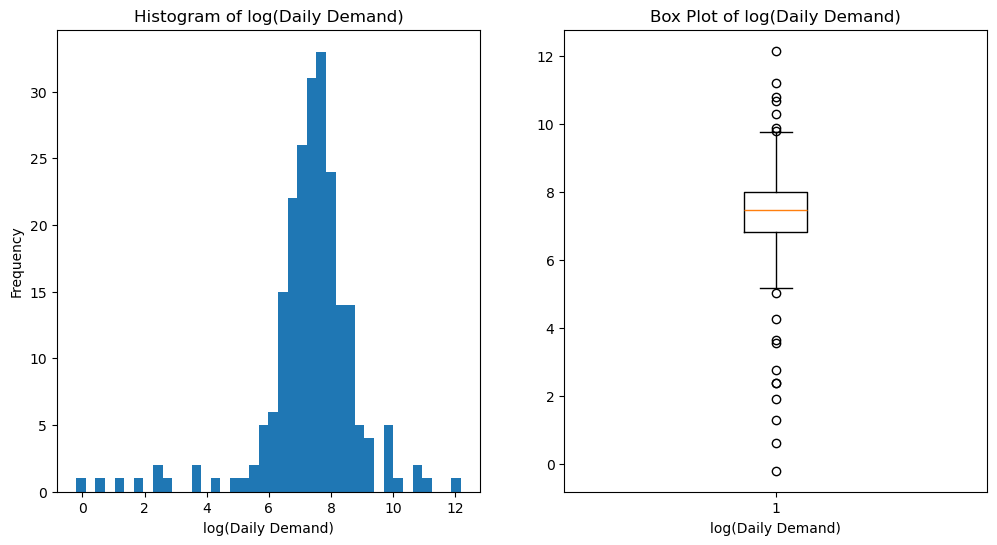

In [16]:
selected_demand = post_covid_mean_daily_train_demand[['Station_Name', 'Total_Demand', 'geometry']]
selected_demand = selected_demand.groupby(['Station_Name', 'geometry'])['Total_Demand'].sum().reset_index()
selected_demand['count'] = np.array(counts)
selected_demand['log_Daily_Demand'] = np.log(selected_demand['Total_Demand'] / selected_demand['count'])
selected_demand = gpd.GeoDataFrame(selected_demand)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(selected_demand['log_Daily_Demand'], bins=40)
ax[0].set_xlabel('log(Daily Demand)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of log(Daily Demand)')

ax[1].boxplot(selected_demand['log_Daily_Demand'])
ax[1].set_xlabel('log(Daily Demand)')
ax[1].set_title('Box Plot of log(Daily Demand)')
plt.show()

<div style="background-color:#E0EDFA;padding:1em;box-sizing: border-box;">

From the hitogram and boxplot of daily train demand, we found that most train stations have around 665 ~ 2981 ($e^{6.5}$ ~ $e^8$) passengers each day. It is also observed that some stations have very low/high demand. We suspect this pattern is related to the population density (residential feature), number of facilities (non-residential feature), and rainfall (environmental feature)

#### 2.2.2 Maps
To get a glance of how the above features related to train demand, we can use maps to visualise

In [17]:
def add_map_components(ax, bound, interval, arrow_pos=None):

    '''
        This function adds cartographic components on the map,
        including: Grid, Axes, Axes Label, North Arrow, Legends, Scale Bar
        It will be applied to every map later in the project
    '''
    # Add orientation arrow
    if arrow_pos == 'left':
        x, y, arrow_length = 0.08, 0.95, 0.1
    if arrow_pos == 'right':
        x, y, arrow_length = 0.92, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=3, headwidth=10),
                ha='center', va='center', fontsize=13, xycoords=ax.transAxes)
    
    # Add axis label
    ax.annotate('Northing', xy=(-0.2,0.45),
                fontsize=11, xycoords=ax.transAxes, rotation=90)
    ax.annotate('Easting', xy=(0.45,-0.12),
                fontsize=11, xycoords=ax.transAxes)
    
    # Remove unnecessary axis
    ax.set_axis_off()

    # Make some offest to avoid map touching boundary
    # Round to create whole number axis
    xmin, ymin, xmax, ymax = bound
    xmin = np.floor(xmin / interval - 0.4) * interval
    ymin = np.floor(ymin / interval - 0.4) * interval
    xmax = np.ceil(xmax / interval + 0.4) * interval
    ymax = np.ceil(ymax / interval + 0.4) * interval
    # Generate lines for graticule
    horizontal = np.arange(np.floor(ymin), np.ceil(ymax), interval)
    vertical = np.arange(np.floor(xmin), np.ceil(xmax), interval)

    # Plot horizontal lines
    for each in horizontal:
        line = LineString([(xmin, each), (xmax, each)])
        ax.annotate(f'{int(each)}', xy=(xmin+20000, each), xytext=(-60, -5),
                    textcoords="offset points")
        ax.plot(*line.xy, color='grey', linewidth=0.6, alpha=0.7)
    
    # Plot vertical lines
    for each in vertical:
        line = LineString([(each, ymin), (each, ymax)])
        ax.annotate(f'{int(each)}', xy=(each, ymin+10000), xytext=(-15, -35),
                    textcoords="offset points", rotation=45)
        ax.plot(*line.xy, color='grey', linewidth=0.6, alpha=0.7)

    # Add Scale Bar
    scalebar = ScaleBar(100, 'cm', 
                        length_fraction=0.15, 
                        location='lower right', 
                        frameon=True, 
                        color='black', 
                        scale_loc='bottom', label_loc='bottom', 
                        font_properties={'size': 12})
    
    ax.add_artist(scalebar)

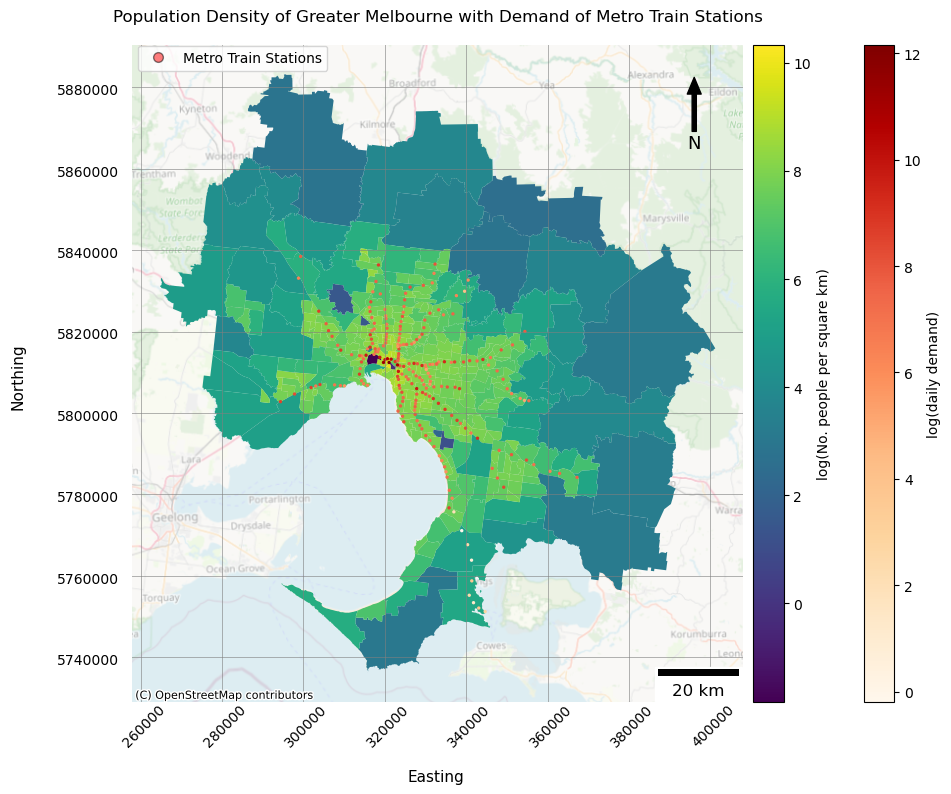

In [18]:
# population density dataset
population = gpd.read_file('data/raw/Estimate_Residential_Population_2023_SA2_GDA2020.gpkg')
population['geometry'] = population['geometry'].to_crs('EPSG:7855')
population = population.loc[population['GCCSA_name_2021'] == 'Greater Melbourne']
population['ERP_2021'] += 1
population['density_2021'] = population['ERP_2021'] / population['Area_km2']
population['log(density_2021)'] = np.log(population['density_2021'])

# Plot population density and tain demand
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cax2 = divider.append_axes("right", size="5%", pad=0.8)

population.plot(column='log(density_2021)',
                ax=ax,
                legend=True,
                cax = cax1,
                legend_kwds={'label': "log(No. people per square km)",'orientation': "vertical"})


selected_demand.plot(column='log_Daily_Demand', 
                                        ax=ax, 
                                        legend=True,
                                        cax=cax2,
                                        legend_kwds={'label': "log(daily demand)",'orientation': "vertical"},
                                        markersize=2, alpha=1, cmap='OrRd')


contextily.add_basemap(ax=ax, 
                       crs = population.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.4)

legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Metro Train Stations')]  

ax.legend(handles=legend, loc=(0.01,0.96))

add_map_components(ax, bound=population.total_bounds, interval=20000, arrow_pos='right')
ax.set_title("Population Density of Greater Melbourne with Demand of Metro Train Stations")
plt.tight_layout()
plt.show()

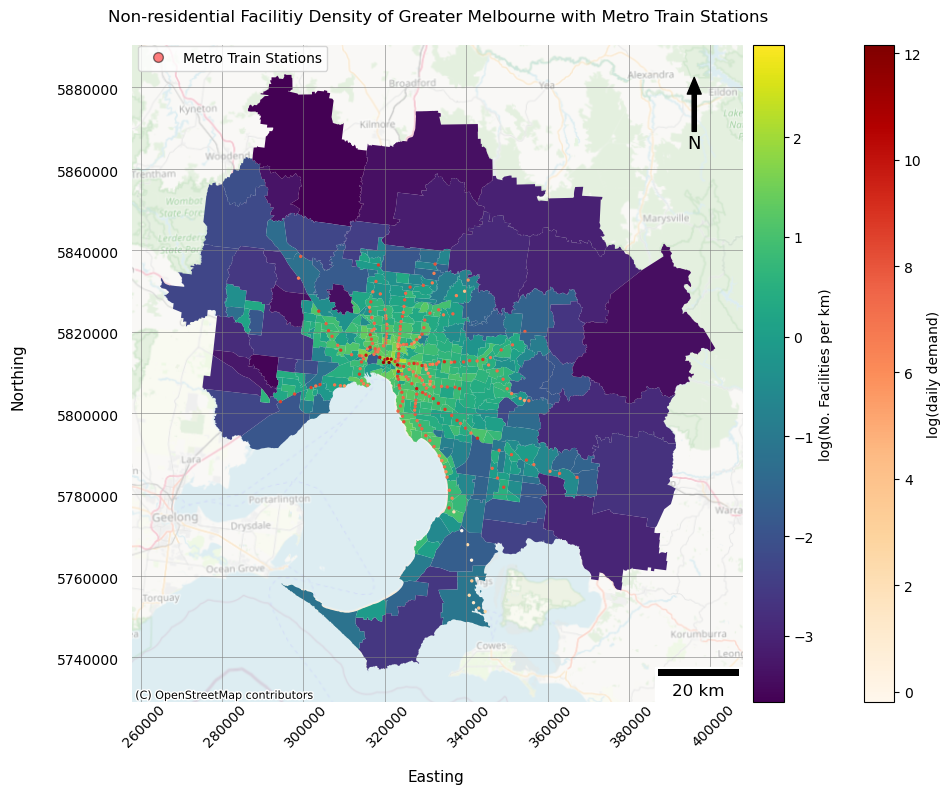

In [19]:
# Read non-residential facilities
hospitals = pd.read_csv('data/raw/hospitals.csv')[['Longitude', 'Latitude']]
schools = pd.read_csv('data/raw/schools.csv')[['Longitude', 'Latitude']]
shopping = pd.read_csv('data/raw/shopping_centre.csv')[['Longitude', 'Latitude']]
sport = pd.read_csv('data/raw/sport_facilities.csv')[['Longitude', 'Latitude']]

facilities = pd.concat([hospitals, schools, shopping, sport])
facility_points = gpd.GeoDataFrame(
    facilities, 
    geometry=gpd.points_from_xy(facilities.Longitude, facilities.Latitude)
)
facility_points.crs = 'epsg:4326'
facility_points = facility_points.to_crs("EPSG:7855")

# Count number of facilities per SA2
joined_df = gpd.sjoin(population, facility_points, how="left", op='intersects')
point_counts = joined_df.groupby('SA2_name_2021').size().reset_index(name='point_count')
df_facilities = population.merge(point_counts, on='SA2_name_2021', how='left')
df_facilities['point_count'].fillna(0, inplace=True) 
df_facilities['point_density'] = df_facilities['point_count'] / df_facilities['Area_km2']
df_facilities['log(point_density)'] = np.log(df_facilities['point_density'])


# Plot facilities and train demand
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cax2 = divider.append_axes("right", size="5%", pad=0.8)

df_facilities.plot(column='log(point_density)', 
                   ax=ax, 
                   cax=cax1,
                   legend=True,
              legend_kwds={'label': "log(No. Facilities per km)",
                           'orientation': "vertical"})

selected_demand.plot(column='log_Daily_Demand', 
                                        ax=ax,
                                        cax=cax2, 
                                        legend=True,
                                        legend_kwds={'label': "log(daily demand)",'orientation': "vertical"},
                                        markersize=2, alpha=1, cmap='OrRd')

legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Metro Train Stations')]  

ax.legend(handles=legend, loc=(0.01,0.96))
contextily.add_basemap(ax=ax, 
                       crs = population.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.4)
add_map_components(ax, bound=population.total_bounds, interval=20000, arrow_pos='right')
ax.set_title("Non-residential Facilitiy Density of Greater Melbourne with Metro Train Stations")
plt.tight_layout()
plt.show()

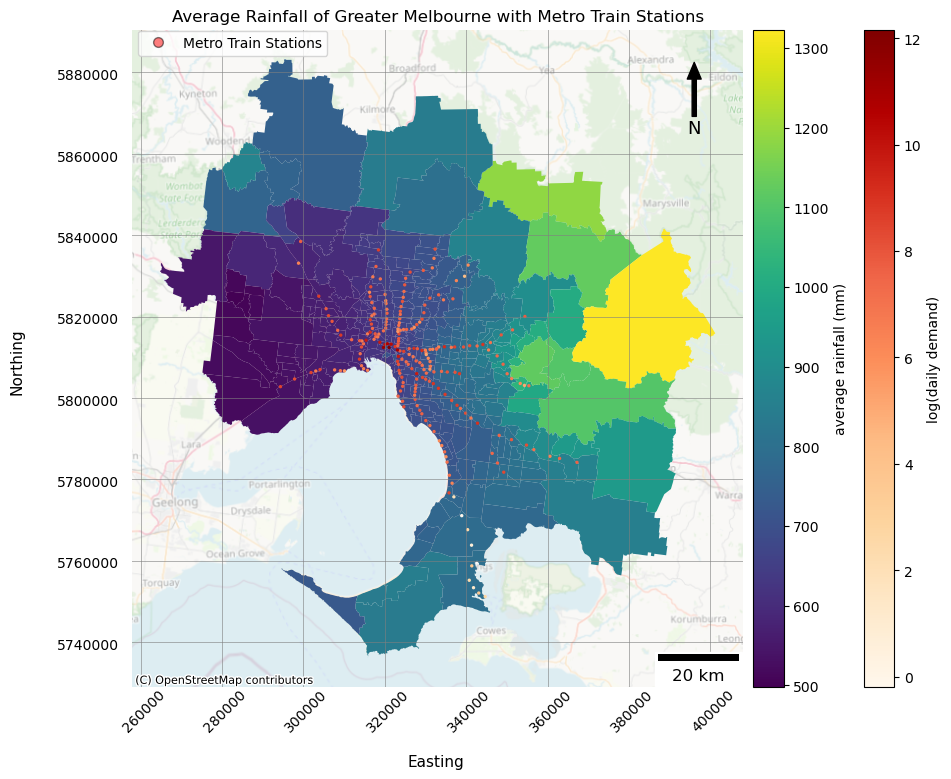

In [20]:
ds = rasterio.open('data/curated/vic_rainfall_grid_epsg7855.tif', 'r')
band1 = ds.read(1)
band1[band1 == ds.nodata] = np.NaN

boundary = gpd.read_file('data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
boundary = boundary[boundary['GCC_NAME21'] == 'Greater Melbourne']
boundary['geometry'] = boundary['geometry'].to_crs('EPSG:7855')

# Calculate zonal statistics
stats = zonal_stats(boundary, band1, stats='mean', affine=ds.transform)
# Add the mean values to the GeoDataFrame
boundary['mean_rainfall_value'] = [stat['mean'] for stat in stats]
boundary = boundary[['SA2_NAME21', 'geometry', 'mean_rainfall_value']]
boundary['mean_rainfall_value'].fillna(boundary['mean_rainfall_value'].mean(), inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cax2 = divider.append_axes("right", size="5%", pad=0.8)
boundary.plot(column='mean_rainfall_value', 
              ax=ax, 
              cax=cax1,
              legend=True,
              legend_kwds={'label': "average rainfall (mm)",
                           'orientation': "vertical"})

selected_demand.plot(column='log_Daily_Demand', 
                                        ax=ax, 
                                        cax=cax2,
                                        legend=True,
                                        legend_kwds={'label': "log(daily demand)",'orientation': "vertical"},
                                        markersize=2, alpha=1, cmap='OrRd')

legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Metro Train Stations')]  

ax.legend(handles=legend, loc=(0.01,0.96))
contextily.add_basemap(ax=ax, 
                       crs = population.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.4)
add_map_components(ax, bound=population.total_bounds, interval=20000, arrow_pos='right')
ax.set_title("Average Rainfall of Greater Melbourne with Metro Train Stations")
plt.tight_layout()
plt.show()

<div style="background-color:#E0EDFA;padding:1em;box-sizing: border-box;">

The first map (population):\
The polygons show population density of each SA2 region in Greater Melbourne, and points represent daily train demand in each station. We observe a positive correlation between mean daily train demand and population, suggesting that local population statistics around each station may positively influence train demand. 

The second map (facilities):\
The polygons show non-residential facility density of each SA2 region in Greater Melbourne, and points represent daily train demand in each station. A similar correlation is observed. More such facilities may foster the train demand of nearby stations.

The third map (rainfall):\
The polygons show average rainfall of each SA2 region in Greater Melbourne, and points represent daily train demand in each station. It does not show a clear relationship between these two variables. However, we still decided to include it as a measure to predict demand, because relationship between the rainfall and the train demand might be non-linear, which can be missed using ESDA. Additionally, there may be interaction effects: rainfall might not show a strong relationship on its own but could have a significant effect when combined with other features.

#### 2.2.3 Pivot Table 
To numerically examine the relationship between train demand and above features, we can extract some representative samples

In [21]:
SA2_pivot = boundary.copy()

# Get features of each SA2
SA2_pivot = SA2_pivot.merge(df_facilities[['SA2_name_2021', 'point_density']], left_on='SA2_NAME21', right_on='SA2_name_2021')
SA2_pivot = SA2_pivot.merge(population[['SA2_name_2021', 'density_2021']], on='SA2_name_2021')
SA2_pivot.drop(['SA2_name_2021'], axis=1, inplace=True)
SA2_pivot.columns = ['SA2_NAME21', 'geometry', 'mean_rainfall_value', 'facility_density', 'population_density']
SA2_pivot = gpd.sjoin(selected_demand, SA2_pivot, how='left', predicate='within')
SA2_pivot.drop(['index_right', 'Total_Demand', 'geometry', 'Station_Name'], axis=1, inplace=True)

# Each SA2 may have multiple train demand because there are multiple stations
pivot_result = SA2_pivot.groupby('SA2_NAME21').agg({'log_Daily_Demand': lambda x: np.log(np.sum(np.exp(x))),
 'mean_rainfall_value': 'first', 
 'facility_density': 'first', 
 'population_density': 'first'}).reset_index()


In [22]:
pivot_result.sort_values('log_Daily_Demand').iloc[:5]

SA2_NAME21  log_Daily_Demand  mean_rainfall_value  \
116                Somerville          2.596740           785.125219   
57          Hastings - Somers          4.655814           794.780172   
45              Fitzroy North          5.692720           645.665161   
68   Ivanhoe East - Eaglemont          5.858918           700.937134   
66                Hurstbridge          5.936828           764.192749   

     facility_density  population_density  
116          0.178946          159.295806  
57           0.339811          222.677140  
45           4.790228         5167.857571  
68           0.467628         1823.750848  
66           0.471631          241.003632

In [23]:
pivot_result.sort_values('log_Daily_Demand', ascending=False).iloc[:5]

SA2_NAME21  log_Daily_Demand  mean_rainfall_value  \
78          Melbourne CBD - West         12.262321           709.375430   
35                     Docklands         11.213779           622.929199   
108  Richmond (South) - Cremorne         10.954706           655.940332   
77         Melbourne CBD - North         10.674699           709.375430   
76          Melbourne CBD - East         10.308315           630.992554   

     facility_density  population_density  
78           5.969555        16017.311710  
35           2.864157         6508.183306  
108          3.030939         4191.555338  
77          10.683761        30913.461538  
76          18.703242        12618.453865

In [24]:
col = pivot_result['log_Daily_Demand']
max_value = col.max()
q3_value = col.quantile(0.75)
median_value = col.median()
q1_value = col.quantile(0.25)
min_value = col.min()

# Get some representative numbers
max_row = pivot_result.iloc[(col - max_value).abs().idxmin()]
q3_row = pivot_result.iloc[(col - q3_value).abs().idxmin()]
median_row = pivot_result.iloc[(col - median_value).abs().idxmin()]
q1_row = pivot_result.iloc[(col - q1_value).abs().idxmin()]
min_row = pivot_result.iloc[(col - min_value).abs().idxmin()]

summary_df = pd.DataFrame([max_row, q3_row, median_row, q1_row, min_row],
                          index=['Max', 'Q3', 'Median', 'Q1', 'Min'])

# Display the summary DataFrame
summary_df

SA2_NAME21  log_Daily_Demand  mean_rainfall_value  \
Max     Melbourne CBD - West         12.262321           709.375430   
Q3          Richmond - North          8.481467           651.362976   
Median        Croydon - East          7.945300           905.999295   
Q1             Ringwood East          7.453069           868.288303   
Min               Somerville          2.596740           785.125219   

        facility_density  population_density  
Max             5.969555        16017.311710  
Q3              8.838975         7318.151094  
Median          2.099232         2005.013460  
Q1              1.596951         2273.206358  
Min             0.178946          159.295806

<div style="background-color:#E0EDFA;padding:1em;box-sizing: border-box;">

The first two pivot tables show the 5 regions with most and least train demand. We found that both population and facility density seems to be positively correlated with train demand, but there is an outlier Fitzroy North. Rainfall seems to have a negative relationship, but not significant, which need further investigation.

The third pivot table summarises the five main statistics of daily train demand. It is clear that demand maximum (Melbourne CBD - West) and minimum (Somerville) have very different values in all other attributes, but patterns within the middle range (first quantile to third quantile) seems unclear.

These tables suggests that there is likely to be relationships between daily train demand and these attributes. However, non-linear relationship may exist due to spatial autocorrelations or interaction between attributes.

### 2.3 Analysing Spatial Autocorrelation
Before any implementations of spatial forecasting techniques, we want to first show the spatial property of train demand.
- Getis and Ord’s G: It identifies statistically significant hot spots and cold spots by evaluating the concentration of high or low values in the neighborhood.
- Local Indicators of Spatial Association (LISA): LISA helps to identify local clusters and spatial outliers. It decomposes global measures of spatial association into contributions for each observation.


#### 2.3.1 Local Indicators of Spatial Association (LISA)


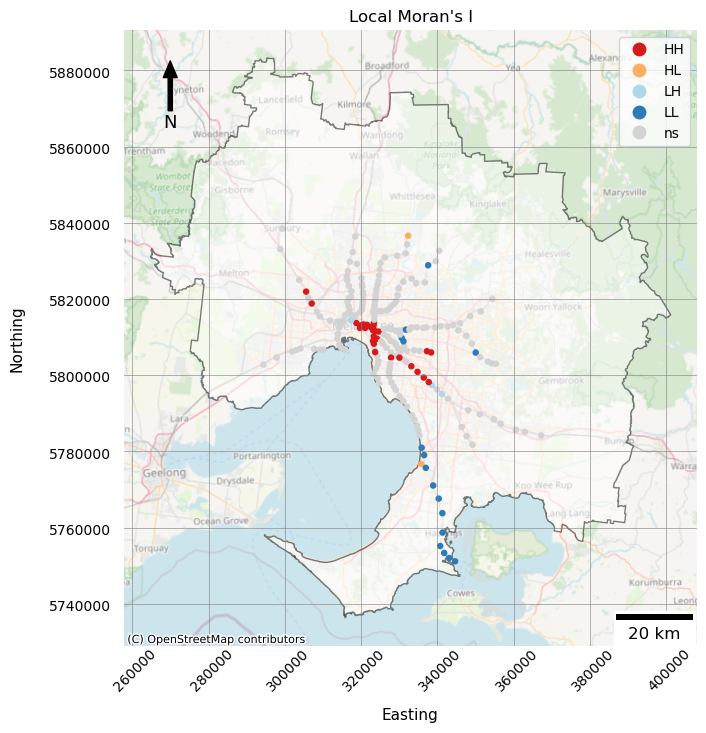

In [25]:
demand = gpd.read_file('data/curated/train_demand/mean_daily_trains_demand_post_covid.gpkg')
counts = demand.groupby('Station_Name').count()['Unnamed: 0']

demand = demand[['Station_Name', 'Total_Demand', 'geometry']]
demand = demand.groupby(['Station_Name', 'geometry'])['Total_Demand'].sum().reset_index()
demand['count'] = np.array(counts)
demand['log_Daily_Demand'] = np.log(demand['Total_Demand'] / demand['count'])
demand = gpd.GeoDataFrame(demand)

GCCSA = gpd.read_file('data/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp')
GCCSA = GCCSA.to_crs("EPSG:7855")
GreaterMelbourne = GCCSA[GCCSA['GCC_NAME21'] == 'Greater Melbourne']


# generating weight matrix (w) from the dataframe
w = weights.KNN.from_dataframe(demand, k = 7)

# Row-standardization
w.transform = "R"

lisa = esda.moran.Moran_Local(demand['log_Daily_Demand'], w) 

fig, ax = plt.subplots(figsize=(10, 8))
GreaterMelbourne.plot(ax = ax, facecolor="w", edgecolor="k", linewidth=1, alpha = 0.5)

esdaplot.lisa_cluster(lisa, demand, p=0.1, ax=ax, markersize=10)
ax.axis('on')

# adding basemap
contextily.add_basemap(ax, crs= GreaterMelbourne.crs.to_string(), alpha = 0.6, source = contextily.providers.OpenStreetMap.Mapnik)
add_map_components(ax=ax, bound=GreaterMelbourne.total_bounds, interval=20000, arrow_pos='left')
ax.set_title('Local Moran\'s I', fontsize = 12)
plt.show()

<div style="background-color:#E0EDFA;padding:1em;box-sizing: border-box;">

From LISA, we can identify specific train stations with unusual patterns in the neighbourhood. Stations around Melbourne CBD have high train demand and significantly surrounded by other high demand stations. This pattern also exist for some stations at south east of Melbourne City, indidating a potential cluster of hotspot. However, there are stations with low demand itself but high demand in their neighbours (LH). It is possible that customers near these stations are attracted to their neighbours due to train service and accessibility factors.

Similarly, most stations in the south Greater Melbourne have low train demand, but there is one station (Frankston) shows a significantly higher demand (HL). This may indicate that the station is a major hub or destination on the line due to spcial infrastructures or residential clusters. The remaining section from Frankston to Stony Point shows that the area may have low population density or less commercial activity, leading to lower passenger numbers.

#### 2.3.2 Getis and Ord’s G

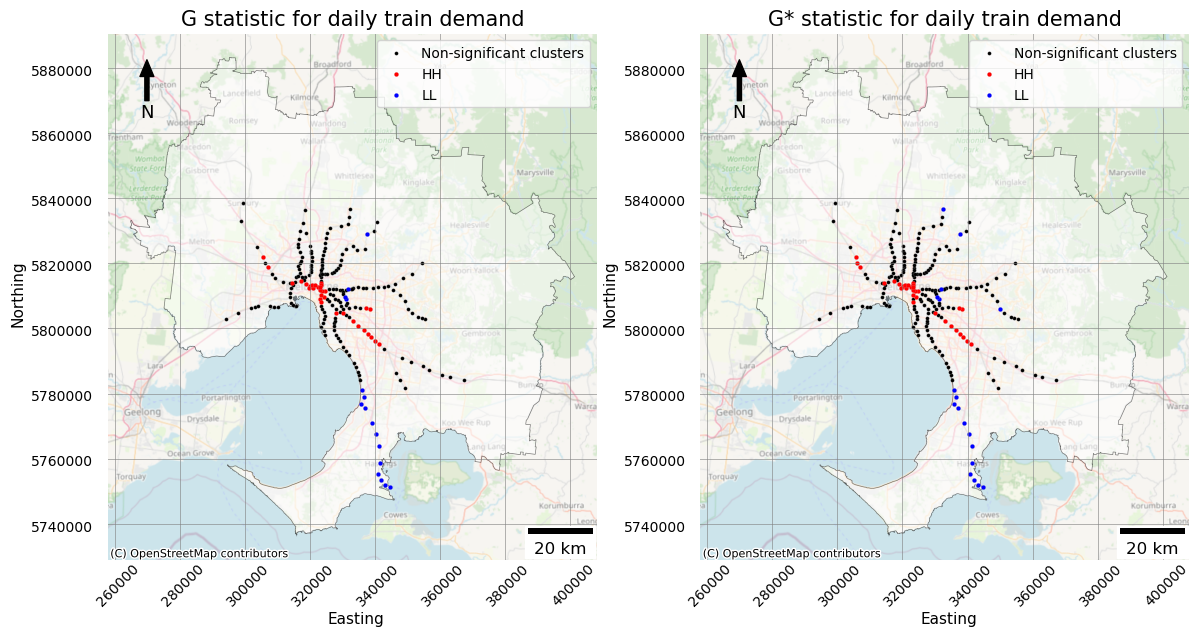

In [26]:
def g_map(g, db, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"

    # Break observations into significant or not
    sig = g.p_sim < 0.1

    # Plot non-significant clusters
    ns = db.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="k", edgecolor=ec, markersize = 7, linewidth=0.1, label = 'Non-significant clusters')
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1, markersize=10, label = 'HH')
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1, markersize=10, label = 'LL')
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic for daily train demand", size=15)
    ax.set_axis_off()
    return ax

getis_ord_i = esda.getisord.G_Local(demand['log_Daily_Demand'], w) 
getis_ord_i_star = esda.getisord.G_Local(demand['log_Daily_Demand'], w, star = True) 

# Setup figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 7))
# Loop over the two statistics
for g, ax in zip([getis_ord_i, getis_ord_i_star], axs.flatten()):
    # Generate the statistic's map
    GreaterMelbourne.plot(ax = ax, facecolor="w", edgecolor="k", linewidth=0.5, alpha = 0.5)

    ax = g_map(g, demand, ax)
    contextily.add_basemap(
        ax,
        crs=GreaterMelbourne.crs,
        source = contextily.providers.OpenStreetMap.Mapnik,
        alpha = 0.6
    )
    ax.legend()
    add_map_components(ax=ax, bound=GreaterMelbourne.total_bounds, interval=20000, arrow_pos='left')
    
f.tight_layout()
plt.show()

<div style="background-color:#E0EDFA;padding:1em;box-sizing: border-box;">

From G statistics, we observe a similar pattern about the hotspot and coldspot of train demand. Compared to LISA, it provides regional patterns that gives insight in larger scale. Both analyses suggests the existance of spatial randomness, justifying that it is crucial to consider spatial autocorrelation in later techniques since the demand is unlikely to form by Complete Spatial Randomness

### 2.4 Feature Engineering
<a id="Feature Engineering"></a>

Features are created as follows:

- Rainfall feature: This feature will be the mean annual rainfall in the SA2 which contains the station
    
    - during inference, SA2s will use their own SA2's mean annual rainfall

- Census Total fields (i.e. total population): We hypothesise only the population characteristics in a close proximity will impact the station's demand; so we choose to define the proximity as the circle with **radius = average nearest neighbour distance between points** because this will try to prevent feature values of different stations being too similar (which will make the feature useless). ANN reflects the average spacing between stations in Greater Melbourne, providing an empirical measure based on real-world data. When planning for future infrastructure and demand, having a standardised affecting area allows for more straightforward extrapolation and modelling.
    
    - We then proportionate the polygon point data into the proximity based on intersection of SA2 polygons and the circular proximity. Note that since we are working with totals, the denominator in the fraction of intersection percentage is the SA2 area, as totals are an exogenous variable and how much value it proportionates over depends on how much of the original area is within the new proximity.

    $$
    V_{\text{Station}} = \sum_{\text{SA2s}} \left( \frac{A_{\text{overlap}}}{A_{\text{SA2}}} \times V_{\text{SA2}} \right)
    $$
    
    - during inference, SA2s will assume stations are built at the polygon centre, and a circular proximity will be built from there.

- Census Median fields: We use ANN as radius to build a circular proximity area, with justification exactly the same as above.

    - We then proportionate the polygon point data into the proximity based on intersection of SA2 polygons and the circular proximity. Note that since we are working with medians, the denominator in the fraction of intersection percentage is the proximity area, as medians are an endogenous variable so how much value it proportionates over depends on how much the original SA2 occupies the new proximity.

    $$
    V_{\text{Station}} = \sum_{\text{SA2s}} \left( \frac{A_{\text{overlap}}}{A_{\text{station ANN-radius proximity}}} \times V_{\text{SA2}} \right)
    $$

    - during inference, SA2s will assume stations are built at the polygon centre, and a circular proximity will be built from there.

- Non residential Building features: We use half ANN as radius to build a circular proximity area, using half ANN this time because we don't want the same building to contribute to features for two stations (in real life people would arrive at a specific station to travel to a building). 

    - The feature is then created as a boolean value, taking value 1 if at least one building of the building type for this feature (i.e. School) exists in the proximity, else 0.

    $$
    I_{\text{Building}} = 
    \begin{cases}
    1 & \text{if building(s) exist in } \frac{1}{2} \text{ station ANN-radius proximity} \\
    0 & \text{otherwise}
    \end{cases}
    $$

    - during inference, SA2s will assume stations are built at the polygon centre, and a circular proximity will be built from there.

- Weekday: boolean value which takes on 1 if the day is week day else 0

    $$
    I_{\text{Weekday}} = 
    \begin{cases}
    1 & \text{if weekday} \\
    0 & \text{otherwise}
    \end{cases}
    $$

- Demand for trains at other stations: 
    
    - For Tabular data in Machine Learning: each station's log-demand of the same day will become features for other stations of the same day, with the log-demands weighted down by a Gaussian Kernel depending on distance of stations to the station of interest. To prevent data leak, the weight of own station to own station is set at 0 (no influence).
    
    $$
    w_{ij} = 
    \begin{cases}
    0 & \text{if same station} \\
    \exp\left(-\frac{d_{ij}^2}{2\sigma^2}\right) & \text{otherwise}
    \end{cases}
    $$

    where $\sigma^2$ is the variance of all pairwise distance between stations.


    - For Graph Neural Network: features don't need to be explicitly created - each station goes in with their daily log-demand as feature, and a weights matrix containing weights as defined above will efficiently weigh each stations' demand depending on the station of interest within the model.


#### 2.4.1 Get Stations and SA2 Centroid

We will use SA2 centroid as future inferences

In [27]:
SA2_GreaterMelbourne_2021 = SA2_GreaterMelbourne
SA2_GreaterMelbourne_2021['centre'] = SA2_GreaterMelbourne_2021['geometry'].centroid.apply(lambda x: Point(x.x, x.y))
SA2_GreaterMelbourne_2021_centroid = gpd.GeoDataFrame(SA2_GreaterMelbourne_2021, geometry='centre') 

mean_daily_train_demand_postcovid = gpd.read_file('data/curated/train_demand/mean_daily_trains_demand_post_covid.gpkg')

train_stations_in_sa2_postcovid = gpd.sjoin(mean_daily_train_demand_postcovid, SA2, how='left', predicate='within')

# merge the data to get the polygons because sjoins take out the right's geometry (each gdf should only have 1 geometry)
train_stations_in_sa2_postcovid = train_stations_in_sa2_postcovid.merge(SA2, left_on='SA2_CODE21', right_on='SA2_CODE21')
train_stations_in_sa2_postcovid = train_stations_in_sa2_postcovid[['Station_Name', 'Passenger_Boardings', 'Passenger_Alightings',
       'Total_Demand', 'log_Passenger_Boardings', 'log_Passenger_Alightings',
       'log_Total_Demand', 'geometry_y', 'SA2_NAME21_x']]
train_stations_in_sa2_postcovid = train_stations_in_sa2_postcovid.rename(columns={'geometry_y': 'geometry', 'SA2_NAME21_x': 'SA2_NAME21'})
train_stations_in_sa2_postcovid = gpd.GeoDataFrame(train_stations_in_sa2_postcovid, geometry='geometry')

train_stations_in_sa2_postcovid.to_file('data/curated/train_demand/train_stations_in_sa2_postcovid.shp')

# we keep station and suburbs on the same file, so we need to add an indicator to differentiate them

mean_daily_train_demand_postcovid_stations = mean_daily_train_demand_postcovid[['Station_Name', 'geometry']]
mean_daily_train_demand_postcovid_stations['point_type'] = 'station'
mean_daily_train_demand_postcovid_stations = mean_daily_train_demand_postcovid_stations.rename(columns={'Station_Name': 'Point Name'})

SA2_GreaterMelbourne_2021_centroid_suburbs_only = SA2_GreaterMelbourne_2021_centroid[['SA2_NAME21', 'centre']]
SA2_GreaterMelbourne_2021_centroid_suburbs_only['point_type'] = 'suburb'
SA2_GreaterMelbourne_2021_centroid_suburbs_only = SA2_GreaterMelbourne_2021_centroid_suburbs_only.rename(columns={'SA2_NAME21': 'Point Name', 'centre': 'geometry'})

all_points_postcovid = pd.concat([mean_daily_train_demand_postcovid_stations, SA2_GreaterMelbourne_2021_centroid_suburbs_only])

suburbs_with_stations_2021 = train_stations_in_sa2_postcovid['SA2_NAME21'].unique()
all_points_postcovid = all_points_postcovid[~(all_points_postcovid['Point Name'].isin(suburbs_with_stations_2021)) | (all_points_postcovid['point_type'] == 'station')]
all_points_postcovid = all_points_postcovid.drop_duplicates(['Point Name', 'point_type'])
all_points_postcovid.to_file('data/curated/stations/all_points_postcovid_(SA2 without stations).shp')


#### 2.4.2 Get Rainfall Feature

In [28]:
# Read preprocessed data
ds = rasterio.open('data/curated/vic_rainfall_grid_epsg7855.tif', 'r')
band1 = ds.read(1)
band1[band1 == ds.nodata] = np.NaN

boundary = gpd.read_file('data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
boundary = boundary[boundary['GCC_NAME21'] == 'Greater Melbourne']
boundary['geometry'] = boundary['geometry'].to_crs('EPSG:7855')

stations = gpd.read_file('data/curated/train_demand/train_stations_in_sa2_postcovid.shp')
stations = stations[['Station_Na', 'SA2_NAME21']]
stations = stations.drop_duplicates()

# Calculate zonal statistics
stats = zonal_stats(boundary, band1, stats='mean', affine=ds.transform)
# Add the mean values to the GeoDataFrame
boundary['mean_rainfall_value'] = [stat['mean'] for stat in stats]
boundary = boundary[['SA2_NAME21', 'geometry', 'mean_rainfall_value']]
boundary['mean_rainfall_value'].fillna(boundary['mean_rainfall_value'].mean(), inplace=True)

# For simplify later analysis, we map rainfall value on both SA2 and Stations
rainfall_data = pd.merge(boundary, stations, how='left', on='SA2_NAME21')
rainfall_data.drop(['geometry'], axis=1, inplace=True)

os.makedirs('data/curated/ML_features', exist_ok=True)
rainfall_data.to_csv('data/curated/ML_features/rainfall_Station_SA2.csv', index=False)

rainfall_data.head()

SA2_NAME21  mean_rainfall_value Station_Na
0     Brunswick East           651.929850        NaN
1     Brunswick West           634.387207        NaN
2  Pascoe Vale South           636.294250        NaN
3  Brunswick - North           646.838298     Anstey
4  Brunswick - South           639.805420  Brunswick

#### 2.4.3 Derive ANN

We need ANN to create a circular proximity area to create features for each station (proportionate polygon feature values based on intersection of polygons and circle)

In [29]:
stations_postcovid = gpd.read_file('data/curated/stations/stations_postcovid.gpkg')

def get_ann(df):
    coordinates = list()
    for index, row in df.iterrows():
        coordinates.append((row.geometry.x, row.geometry.y))

    coordinate_array = np.array(coordinates)
    point_pattern = PointPattern(coordinate_array)
    return  point_pattern.mean_nnd.round(3)

ANN = get_ann(stations_postcovid)
print(ANN)

1420.443


#### 2.4.4 Get data within ANN

Create features for each station and SA2

In [30]:
# facilities features
# use half ann as circular proximity

all_points_postcovid = gpd.read_file('data/curated/stations/all_points_postcovid_(SA2 without stations).shp')

hospitals = pd.read_csv('data/raw/hospitals.csv')
schools = pd.read_csv('data/raw/schools.csv')
shopping_centres = pd.read_csv('data/raw/shopping_centre.csv')
sport_facilities = pd.read_csv('data/raw/sport_facilities.csv')
census = pd.read_csv('data/raw/SA2-T02_Selected_Medians_and_Averages.csv/abs_2021census_t02_aust_sa2-8898358042715570011.csv')
census2 = gpd.read_file('data/raw/Estimate_Residential_Population_2023_SA2_GDA2020.gpkg')

census2 = census2[census2['State_name_2021'] == 'Victoria']
census_df_list = []
for id, group_df in census2[['SA2_name_2021', 'SA2_code_2021', 'Area_km2',
       'Pop_density_2023_people_per_km2']].groupby(['SA2_name_2021', 'SA2_code_2021']):
    
    group_df['total_population'] = group_df['Area_km2'] * group_df['Pop_density_2023_people_per_km2']
    census_df_list.append(group_df)

census_df = pd.concat(census_df_list)
census_df = pd.merge(census_df, census, left_on='SA2_code_2021', right_on=' sa2_code_2021')

def process_facilities(df):
    df['geometry'] = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")
    gdf = gdf.to_crs("EPSG:7855")
    return gdf[['geometry']]

hospitals = process_facilities(hospitals)
schools = process_facilities(schools)
shopping_centres = process_facilities(shopping_centres)
sport_facilities = process_facilities(sport_facilities)

In [31]:
half_ANN = ANN/2

# finds the circles with radius ANN and ANN/2 around each point
all_points_postcovid['circle_ann'] = all_points_postcovid['geometry'].buffer(ANN)
all_points_postcovid['circle_half_ann'] = all_points_postcovid['geometry'].buffer(half_ANN)

all_points_postcovid_ann = all_points_postcovid.copy()
all_points_postcovid_half_ann = all_points_postcovid.copy()

all_points_postcovid_ann = all_points_postcovid_ann.set_geometry('circle_ann')
all_points_postcovid_half_ann = all_points_postcovid_half_ann.set_geometry('circle_half_ann')

all_points_postcovid_ann['circle_area'] = all_points_postcovid_ann.area


def get_included_facilities(df):
    # find the points that intersect with the circles of half ann
    df_half_ann = gpd.sjoin(df, all_points_postcovid_half_ann, op='intersects')

    # find unique point names (all points here had half ann circle intersected with a building)
    stations_with_facility = df_half_ann['Point Name'].unique()
    return stations_with_facility


# add feature onto all_points_postcovid
all_points_postcovid['has_school'] = all_points_postcovid['Point Name'].apply(lambda x: 1 if x in get_included_facilities(schools) else 0)
all_points_postcovid['has_sport_facility'] = all_points_postcovid['Point Name'].apply(lambda x: 1 if x in get_included_facilities(sport_facilities) else 0)
all_points_postcovid['has_shopping_centre'] = all_points_postcovid['Point Name'].apply(lambda x: 1 if x in get_included_facilities(shopping_centres) else 0)
all_points_postcovid['has_hospital'] = all_points_postcovid['Point Name'].apply(lambda x: 1 if x in get_included_facilities(hospitals) else 0)

In [32]:
# census data 
# use ANN as circular proximity

census = pd.merge(SA2_GreaterMelbourne_2021[['SA2_NAME21', 'geometry']], census_df, left_on = 'SA2_NAME21', right_on = 'SA2_name_2021', how = 'right')
census['area'] = census.geometry.area

# find overlapping area
all_points_postcovid_ann = gpd.overlay(all_points_postcovid_ann, census, how = 'intersection')
all_points_postcovid_ann['intersection_area'] = all_points_postcovid_ann.geometry.area
all_points_postcovid_ann['sa2_intersection_percentage'] = all_points_postcovid_ann['intersection_area']/all_points_postcovid_ann['area']
all_points_postcovid_ann['circle_intersection_percentage'] = all_points_postcovid_ann['intersection_area']/all_points_postcovid_ann['circle_area']

all_points_postcovid_ann1 = all_points_postcovid_ann[['Point Name',
       'total_population',
        'sa2_intersection_percentage']]

all_points_postcovid_ann2 = all_points_postcovid_ann[['Point Name',
       'average_hh_size_c2021', ' med_tot_hh_inc_wee_c2021',
       ' avg_num_p_per_brm_c2021', ' med_age_persns_c2021',
       ' med_rent_weekly_c2021', ' med_mortg_rep_mon_c2021',
       ' med_person_inc_we_c2021', ' med_famly_inc_we_c2021',
       'circle_intersection_percentage']]

# process in following way: total - then take the intersection area's percentage of sa2
for col in all_points_postcovid_ann1.columns[1:]:
    if col not in ['Point Name', 'sa2_intersection_percentage']:
        all_points_postcovid_ann1[col] = all_points_postcovid_ann1[col] * all_points_postcovid_ann1['sa2_intersection_percentage']

# process in following way: avearge/median - then take the intersection area's percentage of circle
for col in all_points_postcovid_ann2.columns[1:]:
    if col not in ['Point Name', 'circle_intersection_percentage']:
        all_points_postcovid_ann2[col] = all_points_postcovid_ann2[col] * all_points_postcovid_ann2['circle_intersection_percentage']

# Group by 'Point Name' and sum up
all_points_postcovid_ann1_grouped = all_points_postcovid_ann1.groupby('Point Name').sum().reset_index()
all_points_postcovid_ann2_grouped = all_points_postcovid_ann2.groupby('Point Name').sum().reset_index()

all_points_postcovid_ann1_grouped = all_points_postcovid_ann1_grouped.drop(columns=['sa2_intersection_percentage'])
all_points_postcovid_ann2_grouped = all_points_postcovid_ann2_grouped.drop(columns=['circle_intersection_percentage'])

all_points_postcovid = pd.merge(all_points_postcovid, all_points_postcovid_ann1_grouped, how = 'left', on = 'Point Name')
all_points_postcovid = pd.merge(all_points_postcovid, all_points_postcovid_ann2_grouped, how = 'left', on = 'Point Name')

all_points_postcovid = all_points_postcovid.drop(['geometry', 'circle_ann', 'circle_half_ann'], axis = 1)


all_points_postcovid.to_csv('data/curated/ML_features/census_and_buildings_postcovid.csv', index = False)


#### 2.4.5 Compute Geographical Weights

In [33]:
# create pariwise distance matrix so we can weigh down other stations' demand based on distance with station of interest we are predicting for, 
# which we can then use as features for our models

demand = pd.read_csv('data/curated/train_demand/daily_trains_demand_post_covid.csv')
stations = gpd.read_file('data/curated/stations/all_points_postcovid_(SA2 without stations).shp')
stations = stations.to_crs("EPSG:7855")

def get_weight(df, var=None):
    df = df.sort_values('Point Name')
    df['Point Name'] = df['Point Name'].apply(lambda x: re.sub('~', '', x))
    coords = df['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist()

    # Compute pairwise distances
    dist_matrix = distance_matrix(coords, coords)
    dist_df = pd.DataFrame(dist_matrix, index=list(df['Point Name']), columns=list(df['Point Name']))

    # Varience can be given or computed from existing locations
    if var:
        variance = var
    else:
        variance = np.var(dist_matrix.flatten())

    # Calculate geographical weight according to formula
    W = np.exp(-1 * np.power(dist_df,2) / (2 * variance)) - np.eye(len(df))
    dict_data = W.to_dict(orient='index')
    return W, dict_data, variance

# Weight with only stations
W, dict_stations, variance = get_weight(stations[stations['point_type'] == 'station'])
with open('data/curated/ML_features/station_weights.json', 'w', encoding='utf-8') as f:
    json.dump(dict_stations, f, ensure_ascii=False, indent=4)
W.to_csv('data/curated/ML_features/station_weights.csv')

stations_self = stations[stations['point_type'] == 'station']
stations_missing = stations[stations['point_type'] == 'suburb']
stations_missing['Point Name'] = stations_missing['Point Name'].apply(lambda x: '~(SA2)' + x)
stations_and_SA2 = pd.concat([stations_self, stations_missing])

# Weight with stations and SA2 centre
W, dict_stations_and_SA2, variance = get_weight(stations_and_SA2, variance)
with open('data/curated/ML_features/station_weights_withSA2.json', 'w', encoding='utf-8') as f:
    json.dump(dict_stations, f, ensure_ascii=False, indent=4)
W.to_csv('data/curated/ML_features/station_weights_withSA2.csv')

### 2.5 Machine Learning Features (putting features created above together with their target variable)
<a id="premodelling"></a>

Each training sample point is one daily station's observation. 

The target of the regression is $\log(daily\_totaly\_demand)$ which is the **logged value of the sum of alightings and boardings at that station for the day**.

After features are created, the sample points from the first 70% of days in the training data are made into a training set, the next 15% validation set (for hyperparameter optimisation) and last 15% test (final out of sample). All data are z-scored normalised based on $\mu$ and $\sigma$ of the training set.


#### 2.5.1 Create Other Stations' demand data

In [34]:
# get tabular data for models other than GNN
daily_trains_demand_post_covid = pd.read_csv('data/curated/train_demand/daily_trains_demand_post_covid.csv')
mean_daily_trains_demand_post_covid = pd.read_csv('data/curated/train_demand/mean_daily_trains_demand_post_covid.csv')

# have 2 sets of data for inference - one weekday and one weekend
daily_trains_demand_post_covid_weekday = daily_trains_demand_post_covid[(daily_trains_demand_post_covid['Weekday'] == 1)]
daily_trains_demand_post_covid_weekend = daily_trains_demand_post_covid[(daily_trains_demand_post_covid['Weekday'] == 0)]

# add rows together
mean_daily_trains_demand_post_covid_weekday = pd.DataFrame()

for id, station_data in daily_trains_demand_post_covid_weekday.drop(['Business_Date', 'Weekday', 'PublicHoliday', 'Unnamed: 0'], axis=1).groupby('Station_Name'):
    station_data = station_data.drop('Station_Name', axis=1)
    station_data_mean = station_data.mean()
    station_data_mean = pd.DataFrame(station_data_mean).T
    station_data_mean['Station_Name'] = id
    mean_daily_trains_demand_post_covid_weekday = pd.concat([mean_daily_trains_demand_post_covid_weekday, station_data_mean], axis=0)


mean_daily_trains_demand_post_covid_weekend = pd.DataFrame()

for id, station_data in daily_trains_demand_post_covid_weekend.drop(['Business_Date', 'Weekday', 'PublicHoliday', 'Unnamed: 0'], axis=1).groupby('Station_Name'):
    station_data = station_data.drop('Station_Name', axis=1)
    station_data_mean = station_data.mean()
    station_data_mean = pd.DataFrame(station_data_mean).T
    station_data_mean['Station_Name'] = id
    mean_daily_trains_demand_post_covid_weekend = pd.concat([mean_daily_trains_demand_post_covid_weekend, station_data_mean], axis=0)

mean_daily_trains_demand_post_covid_weekday['log_Total_Demand'] = np.log(mean_daily_trains_demand_post_covid_weekday['Total_Demand'])
mean_daily_trains_demand_post_covid_weekend['log_Total_Demand'] = np.log(mean_daily_trains_demand_post_covid_weekend['Total_Demand'])
mean_daily_trains_demand_post_covid_weekday['log_Passenger_Alightings'] = np.log(mean_daily_trains_demand_post_covid_weekday['Passenger_Alightings'])
mean_daily_trains_demand_post_covid_weekend['log_Passenger_Alightings'] = np.log(mean_daily_trains_demand_post_covid_weekend['Passenger_Alightings'])
mean_daily_trains_demand_post_covid_weekday['log_Passenger_Boardings'] = np.log(mean_daily_trains_demand_post_covid_weekday['Passenger_Boardings'])
mean_daily_trains_demand_post_covid_weekend['log_Passenger_Boardings'] = np.log(mean_daily_trains_demand_post_covid_weekend['Passenger_Boardings'])

In [35]:
def get_daily_demand_in_rows(demand_df: pd.DataFrame, feature: str):

    try:
        df_with_feature = demand_df[['Station_Name', 'Business_Date', feature]]
    except:
        df_with_feature = demand_df[['Station_Name', feature]]

    station_df_list = []

    for id, station_df in tqdm(df_with_feature.groupby('Station_Name')):

        station_df = station_df.rename({feature: f'{feature}_{id}'}, axis=1)
        station_df = station_df.drop('Station_Name', axis=1)
        station_df_list.append(station_df)

    for i, station_df in enumerate(station_df_list):
        if i == 0:
            merged_df = station_df
        else:
            try:
                merged_df = pd.merge(merged_df, station_df, on='Business_Date', how='outer')
            except:
                merged_df = pd.concat([merged_df, station_df], axis=0)

    merged_df = merged_df.fillna(0)
    return merged_df

log_demand_postcovid = get_daily_demand_in_rows(daily_trains_demand_post_covid, 'log_Total_Demand')
log_alighting_postcovid = get_daily_demand_in_rows(daily_trains_demand_post_covid, 'log_Passenger_Alightings')
log_boarding_postcovid = get_daily_demand_in_rows(daily_trains_demand_post_covid, 'log_Passenger_Boardings')

mean_daily_trains_demand_post_covid_weekday = mean_daily_trains_demand_post_covid_weekday.sort_values('Station_Name')
mean_daily_trains_demand_post_covid_weekday = mean_daily_trains_demand_post_covid_weekday.set_index('Station_Name')

mean_daily_trains_demand_post_covid_weekend = mean_daily_trains_demand_post_covid_weekend.sort_values('Station_Name')
mean_daily_trains_demand_post_covid_weekend = mean_daily_trains_demand_post_covid_weekend.set_index('Station_Name')

def get_daily_demand_in_rows_inference(df, feature):
    return df[[feature]].T

log_mean_demand_postcovid_weekday = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekday, 'log_Total_Demand')
log_mean_alighting_postcovid_weekday = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekday, 'log_Passenger_Alightings')
log_mean_boarding_postcovid_weekday = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekday, 'log_Passenger_Boardings')

log_mean_demand_postcovid_weekend = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekend, 'log_Total_Demand')
log_mean_alighting_postcovid_weekend = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekend, 'log_Passenger_Alightings')
log_mean_boarding_postcovid_weekend = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekend, 'log_Passenger_Boardings')

  0%|          | 0/223 [00:00<?, ?it/s]

100%|██████████| 223/223 [00:00<00:00, 2502.27it/s]


In [36]:
log_demand_postcovid.to_csv('data/curated/ML_features/log_demand_postcovid.csv', index=False)
log_alighting_postcovid.to_csv('data/curated/ML_features/log_alighting_postcovid.csv', index=False)
log_boarding_postcovid.to_csv('data/curated/ML_features/log_boarding_postcovid.csv', index=False)

log_mean_demand_postcovid_weekday.to_csv('data/curated/ML_features/log_mean_demand_postcovid_weekday.csv', index=False)
log_mean_alighting_postcovid_weekday.to_csv('data/curated/ML_features/log_mean_alighting_postcovid_weekday.csv', index=False)
log_mean_boarding_postcovid_weekday.to_csv('data/curated/ML_features/log_mean_boarding_postcovid_weekday.csv', index=False)
log_mean_alighting_postcovid_weekend.to_csv('data/curated/ML_features/log_mean_alighting_postcovid_weekend.csv', index=False)
log_mean_boarding_postcovid_weekend.to_csv('data/curated/ML_features/log_mean_boarding_postcovid_weekend.csv', index=False)
log_mean_demand_postcovid_weekend.to_csv('data/curated/ML_features/log_mean_demand_postcovid_weekend.csv', index=False)

#### 2.5.2 Weight the Train Demand Features


In [37]:
station_weights_withSA2 = pd.read_csv('data/curated/ML_features/station_weights_withSA2.csv')
station_weights = pd.read_csv('data/curated/ML_features/station_weights.csv')

station_with_sa2_list_dict = {k:i for i, k in enumerate(station_weights_withSA2['Unnamed: 0'])}
station_list_dict = {k:i for i, k in enumerate(station_weights['Unnamed: 0'])}
reverse_station_with_sa2_list_dict = {i:k for i, k in enumerate(station_weights_withSA2['Unnamed: 0'])}
reverse_station_list_dict = {i:k for i, k in enumerate(station_weights['Unnamed: 0'])}

station_weights_withSA2.set_index('Unnamed: 0', inplace=True)
station_weights.set_index('Unnamed: 0', inplace=True)

with open('data/curated/ML_features/station_weights_withSA2.json', 'w') as f:
    json.dump(station_with_sa2_list_dict, f)

with open('data/curated/ML_features/station_weights.json', 'w') as f:
    json.dump(station_list_dict, f)

log_demand_postcovid.set_index('Business_Date', inplace=True)
log_alighting_postcovid.set_index('Business_Date', inplace=True)
log_boarding_postcovid.set_index('Business_Date', inplace=True)

def get_weighted_demand(log_demand: pd.DataFrame, station_weights: pd.DataFrame, reverse_station_list_dict: dict):
    results = []

    for station, row in tqdm(station_weights.iterrows()):
        weights = row.values

        for date, row in log_demand.iterrows():
            demand = row.values

            weighted_demand = weights * demand

            # Append to results list
            results.append({
                'Station': station,
                'Date': date,
                **{f'{reverse_station_list_dict[i]}': wd for i, wd in enumerate(weighted_demand)}
            })

    # Convert results list to DataFrame
    weighted_demand_df = pd.DataFrame(results)

    return weighted_demand_df

weighted_log_demand_postcovid = get_weighted_demand(log_demand_postcovid, station_weights, reverse_station_list_dict)
weighted_log_alighting_postcovid = get_weighted_demand(log_alighting_postcovid, station_weights, reverse_station_list_dict)
weighted_log_boarding_postcovid = get_weighted_demand(log_boarding_postcovid, station_weights, reverse_station_list_dict)

223it [00:09, 23.43it/s]
223it [00:09, 22.89it/s]
223it [00:09, 23.46it/s]


In [38]:
def get_weighted_demand_inference(log_demand: pd.DataFrame, station_weights: pd.DataFrame, reverse_station_list_dict: dict):
    results = []

    i = 0
    for station, row in tqdm(station_weights.iterrows()):
        weights = row.values[:223]
        if '(SA2)' not in station:
            continue
        else:
            station = station.split('(SA2)')[1]
 
        for date, row in log_demand.iterrows():
            demand = row.values

            weighted_demand = weights * demand

            # Append to results list
            results.append({
                'Station': reverse_station_list_dict[i+223],
                'Date': date,
                **{f'{reverse_station_list_dict[i]}': wd for i, wd in enumerate(weighted_demand)}
            })

            i += 1

    # Convert results list to DataFrame
    weighted_demand_df = pd.DataFrame(results)

    return weighted_demand_df
weighted_log_mean_demand_postcovid_weekday = get_weighted_demand_inference(log_mean_demand_postcovid_weekday, station_weights_withSA2, reverse_station_with_sa2_list_dict)
weighted_log_mean_alighting_postcovid_weekday = get_weighted_demand_inference(log_mean_alighting_postcovid_weekday, station_weights_withSA2, reverse_station_with_sa2_list_dict)
weighted_log_mean_boarding_postcovid_weekday = get_weighted_demand_inference(log_mean_boarding_postcovid_weekday, station_weights_withSA2, reverse_station_with_sa2_list_dict)

weighted_log_mean_demand_postcovid_weekend = get_weighted_demand_inference(log_mean_demand_postcovid_weekend, station_weights_withSA2, reverse_station_with_sa2_list_dict)
weighted_log_mean_alighting_postcovid_weekend = get_weighted_demand_inference(log_mean_alighting_postcovid_weekend, station_weights_withSA2, reverse_station_with_sa2_list_dict)
weighted_log_mean_boarding_postcovid_weekend = get_weighted_demand_inference(log_mean_boarding_postcovid_weekend, station_weights_withSA2, reverse_station_with_sa2_list_dict)

442it [00:00, 15440.53it/s]


442it [00:00, 15660.44it/s]
442it [00:00, 15758.28it/s]
442it [00:00, 16186.31it/s]
442it [00:00, 16047.18it/s]
442it [00:00, 15997.60it/s]


In [39]:
weighted_log_mean_demand_postcovid_weekday.drop('Date', axis=1, inplace=True)
weighted_log_mean_alighting_postcovid_weekday.drop('Date', axis=1, inplace=True)
weighted_log_mean_boarding_postcovid_weekday.drop('Date', axis=1, inplace=True)

weighted_log_mean_demand_postcovid_weekend.drop('Date', axis=1, inplace=True)
weighted_log_mean_alighting_postcovid_weekend.drop('Date', axis=1, inplace=True)
weighted_log_mean_boarding_postcovid_weekend.drop('Date', axis=1, inplace=True)

weighted_log_demand_postcovid.to_parquet('data/curated/ML_features/weighted_log_demand_postcovid.parquet', index=False)
weighted_log_alighting_postcovid.to_parquet('data/curated/ML_features/weighted_log_alighting_postcovid.parquet', index=False)
weighted_log_boarding_postcovid.to_parquet('data/curated/ML_features/weighted_log_boarding_postcovid.parquet', index=False)

weighted_log_mean_demand_postcovid_weekday.to_parquet('data/curated/ML_features/weighted_log_mean_demand_postcovid_weekday.parquet', index=False)
weighted_log_mean_alighting_postcovid_weekday.to_parquet('data/curated/ML_features/weighted_log_mean_alighting_postcovid_weekday.parquet', index=False)
weighted_log_mean_boarding_postcovid_weekday.to_parquet('data/curated/ML_features/weighted_log_mean_boarding_postcovid_weekday.parquet', index=False)

weighted_log_mean_demand_postcovid_weekend.to_parquet('data/curated/ML_features/weighted_log_mean_demand_postcovid_weekend.parquet', index=False)
weighted_log_mean_alighting_postcovid_weekend.to_parquet('data/curated/ML_features/weighted_log_mean_alighting_postcovid_weekend.parquet', index=False)
weighted_log_mean_boarding_postcovid_weekend.to_parquet('data/curated/ML_features/weighted_log_mean_boarding_postcovid_weekend.parquet', index=False)

#### 2.5.3 Join All Features

In [40]:
daily_trains_demand_post_covid.drop(['Unnamed: 0', 'Passenger_Boardings', 'Passenger_Alightings', 'Total_Demand', 'log_Passenger_Boardings', 'log_Passenger_Alightings'], axis = 1, inplace=True)
rainfall_df = pd.read_csv('data/curated/ML_features/rainfall_Station_SA2.csv')
rainfall_df_stations = rainfall_df[~rainfall_df['Station_Na'].isna()][['mean_rainfall_value', 'Station_Na']]
rainfall_df_sa2 = rainfall_df[rainfall_df['Station_Na'].isna()][['mean_rainfall_value', 'SA2_NAME21']]
rainfall_df_sa2.rename({'SA2_NAME21': 'Station'}, axis=1, inplace=True)

census_and_buildings_postcovid = pd.read_csv('data/curated/ML_features/census_and_buildings_postcovid.csv')
station_ML_data = daily_trains_demand_post_covid.merge(rainfall_df_stations, left_on='Station_Name', right_on='Station_Na', how='left')
station_ML_data.drop(['Station_Na'], axis=1, inplace=True)
station_ML_data = station_ML_data.merge(census_and_buildings_postcovid[census_and_buildings_postcovid['point_type'] == 'station'], left_on = 'Station_Name', right_on='Point Name', how = 'left')


In [41]:

station_ML_data = station_ML_data.merge(weighted_log_demand_postcovid, left_on=['Business_Date', 'Station_Name'], right_on=['Date', 'Station'], how='left', suffixes=('', '_demand'))
station_ML_data = station_ML_data.merge(weighted_log_alighting_postcovid, left_on=['Business_Date', 'Station_Name'], right_on=['Date', 'Station'], how='left', suffixes=('', '_alighting'))
station_ML_data = station_ML_data.merge(weighted_log_boarding_postcovid, left_on=['Business_Date', 'Station_Name'], right_on=['Date', 'Station'], how='left', suffixes=('', '_boarding'))
station_ML_data.drop(['Point Name', 'point_type', 'Station_alighting', 'Station_boarding', 'Date_alighting', 'Date_boarding', 'Station'], inplace=True, axis = 1)

weighted_log_mean_demand_postcovid_weekday['Station'] = weighted_log_mean_demand_postcovid_weekday['Station'].apply(lambda x: x.split('(SA2)')[1])
weighted_log_mean_alighting_postcovid_weekday['Station'] = weighted_log_mean_alighting_postcovid_weekday['Station'].apply(lambda x: x.split('(SA2)')[1])
weighted_log_mean_boarding_postcovid_weekday['Station'] = weighted_log_mean_boarding_postcovid_weekday['Station'].apply(lambda x: x.split('(SA2)')[1])

weighted_log_mean_demand_postcovid_weekend['Station'] = weighted_log_mean_demand_postcovid_weekend['Station'].apply(lambda x: x.split('(SA2)')[1])
weighted_log_mean_alighting_postcovid_weekend['Station'] = weighted_log_mean_alighting_postcovid_weekend['Station'].apply(lambda x: x.split('(SA2)')[1])
weighted_log_mean_boarding_postcovid_weekend['Station'] = weighted_log_mean_boarding_postcovid_weekend['Station'].apply(lambda x: x.split('(SA2)')[1])

In [42]:
SA2_ML_data_weekday = rainfall_df_sa2.copy()
SA2_ML_data_weekday = SA2_ML_data_weekday.merge(census_and_buildings_postcovid[census_and_buildings_postcovid['point_type'] == 'suburb'], left_on = 'Station', right_on='Point Name', how = 'left')

SA2_ML_data_weekday = SA2_ML_data_weekday.merge(weighted_log_mean_demand_postcovid_weekday, left_on=['Station'], right_on=['Station'], how='left', suffixes = ('', '_demand'))
SA2_ML_data_weekday = SA2_ML_data_weekday.merge(weighted_log_mean_alighting_postcovid_weekday, left_on=['Station'], right_on=['Station'], how='left', suffixes = ('', '_alighting'))
SA2_ML_data_weekday = SA2_ML_data_weekday.merge(weighted_log_mean_boarding_postcovid_weekday, left_on=['Station'], right_on=['Station'], how='left', suffixes = ('', '_boarding'))

SA2_ML_data_weekday.drop(['Point Name', 'point_type'], axis=1, inplace=True)
SA2_ML_data_weekday.rename({'Station': 'Station Name'}, axis=1, inplace=True)

SA2_ML_data_weekend = rainfall_df_sa2.copy()
SA2_ML_data_weekend = SA2_ML_data_weekend.merge(census_and_buildings_postcovid[census_and_buildings_postcovid['point_type'] == 'suburb'], left_on = 'Station', right_on='Point Name', how = 'left')

SA2_ML_data_weekend = SA2_ML_data_weekend.merge(weighted_log_mean_demand_postcovid_weekend, left_on=['Station'], right_on=['Station'], how='left', suffixes = ('', '_demand'))
SA2_ML_data_weekend = SA2_ML_data_weekend.merge(weighted_log_mean_alighting_postcovid_weekend, left_on=['Station'], right_on=['Station'], how='left', suffixes = ('', '_alighting'))
SA2_ML_data_weekend = SA2_ML_data_weekend.merge(weighted_log_mean_boarding_postcovid_weekend, left_on=['Station'], right_on=['Station'], how='left', suffixes = ('', '_boarding'))

SA2_ML_data_weekend.drop(['Point Name', 'point_type'], axis=1, inplace=True)
SA2_ML_data_weekend.rename({'Station': 'Station Name'}, axis=1, inplace=True)

SA2_ML_data_weekday['Weekday'] = 1
SA2_ML_data_weekend['Weekday'] = 0

SA2_ML_data = pd.concat([SA2_ML_data_weekday, SA2_ML_data_weekend], axis=0)

os.makedirs('data/curated/ML_data', exist_ok=True)
station_ML_data.to_parquet('data/curated/ML_data/station_ML_data.parquet', index=False)
SA2_ML_data.to_parquet('data/curated/ML_data/SA2_ML_data.parquet', index=False)

#### 2.5.4 Feature Selection
Feature selection is essential in machine learning for improving model performance and simplifying models.By removing irrelevant or redundant features, it reduces overfitting and enhances accuracy, leading to better predictive performance. Additionally, it simplifies models, making them easier to interpret, which is crucial for urban planners who need to understand the model's decisions. This process ensures that predictions about traffic demand are both efficient and effective, providing clearer insights and more reliable guidance for train development.

In this section, we focus on selecting two types of features, census data (predictor) and train demand data (respond variable). We suspect some features in these categories are correlated with each other.

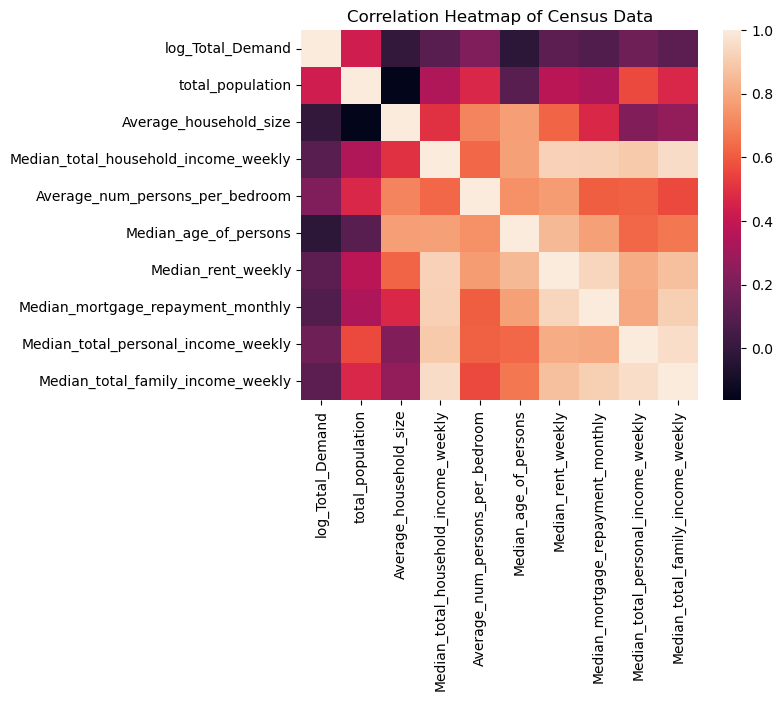

In [43]:
data = pd.read_parquet('data/curated/ML_data/station_ML_data.parquet')
data_census = data[['log_Total_Demand', 
                    'total_population', 'average_hh_size_c2021',
       ' med_tot_hh_inc_wee_c2021', ' avg_num_p_per_brm_c2021',
       ' med_age_persns_c2021', ' med_rent_weekly_c2021',
       ' med_mortg_rep_mon_c2021', ' med_person_inc_we_c2021',
       ' med_famly_inc_we_c2021']]

# Rename for clarity
data_census.columns = ['log_Total_Demand', 
                    'total_population', 'Average_household_size', 'Median_total_household_income_weekly', 
                      'Average_num_persons_per_bedroom', 'Median_age_of_persons',
                      'Median_rent_weekly', 'Median_mortgage_repayment_monthly',
                      'Median_total_personal_income_weekly', 'Median_total_family_income_weekly']
ax = sns.heatmap(data_census.corr())
ax.set_title('Correlation Heatmap of Census Data')
plt.show()

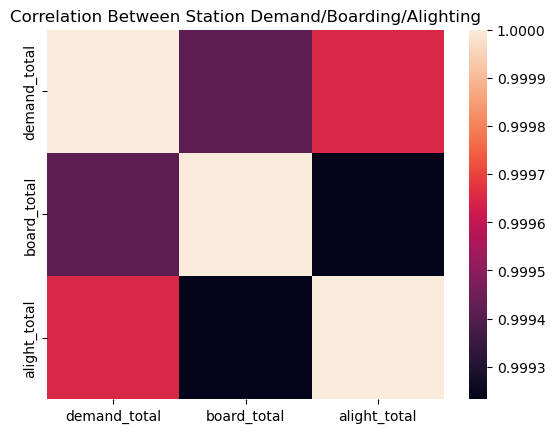

In [44]:
stations = list(data['Station_Name'].unique())
onboards = [x+'_boarding' for x in stations]
alights = [x+'_alighting' for x in stations]
data_demands = data[stations]
data_onborads = data[onboards]
data_alights = data[alights]

data_demands['demand_total'] = data_demands.sum(axis=1) 
data_onborads['board_total'] = data_onborads.sum(axis=1) 
data_alights['alight_total'] = data_alights.sum(axis=1) 

df = pd.DataFrame([data_demands['demand_total'], data_onborads['board_total'] , data_alights['alight_total']]).T
ax = sns.heatmap(df.corr())
ax.set_title('Correlation Between Station Demand/Boarding/Alighting')
plt.show()

<div style="background-color:#E0EDFA;padding:1em;box-sizing: border-box;">

From the correlation heatmap of census related features, *Median_total_household_income_weekly* is highly correlated with the last 4 features. Therefore, we decided to drop those 4 features to reduce complexity

Similarly, in the second correlation heatmap, all three features are highly correlated. Therefore, only one of them is needed (We chose *demand_total*)

#### 2.5.5 Train-Test-Split

In [45]:
station_ML_data = pd.read_parquet('data/curated/ML_data/station_ML_data.parquet')
SA2_ML_data = pd.read_parquet('data/curated/ML_data/SA2_ML_data.parquet')


drop_columns = [
 'average_hh_size_c2021',
 ' med_tot_hh_inc_wee_c2021',
 ' avg_num_p_per_brm_c2021',
 ' med_age_persns_c2021',]
for column in station_ML_data.columns:
    if 'boarding' in column or 'alighting' in column:
        drop_columns.append(column)

station_ML_data = station_ML_data.drop(drop_columns, axis = 1)
SA2_ML_data = SA2_ML_data.drop(drop_columns, axis = 1)

business_dates = station_ML_data['Business_Date'].unique()

train_dates, val_test_dates = train_test_split(business_dates, test_size=0.3, shuffle = False)
val_dates, test_dates = train_test_split(val_test_dates, test_size=0.5, shuffle = False)

ML_train_data = station_ML_data[station_ML_data['Business_Date'].isin(train_dates)]
ML_val_data = station_ML_data[station_ML_data['Business_Date'].isin(val_dates)]
ML_test_data = station_ML_data[station_ML_data['Business_Date'].isin(test_dates)]

numerical_columns = [col for col in station_ML_data if col not in  ['Station_Name',
                                                                    'Business_Date',
                                                                    'Weekday',
                                                                    'PublicHoliday',
                                                                    'has_school', 
                                                                    'has_sport_facility',
                                                                    'has_shopping_centre',
                                                                    'has_hospital', 
                                                                    'Date',
                                                                    'log_Total_Demand']]

In [46]:
# scale the data so all features and targets are centred with std 1
scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit and transform the numerical columns
ML_train_data[numerical_columns] = scaler.fit_transform(ML_train_data[numerical_columns])
ML_val_data[numerical_columns] = scaler.transform(ML_val_data[numerical_columns])
ML_test_data[numerical_columns] = scaler.transform(ML_test_data[numerical_columns])

ML_train_data[['log_Total_Demand']] = y_scaler.fit_transform(ML_train_data[['log_Total_Demand']])
ML_val_data[['log_Total_Demand']] = y_scaler.transform(ML_val_data[['log_Total_Demand']])
ML_test_data[['log_Total_Demand']] = y_scaler.transform(ML_test_data[['log_Total_Demand']])

SA2_ML_data[numerical_columns] = scaler.transform(SA2_ML_data[numerical_columns])

with open('data/curated/ML_data/scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f) 

with open('data/curated/ML_data/y_scaler.pickle', 'wb') as f:
    pickle.dump(y_scaler, f) 

ML_train_data.to_parquet('data/curated/ML_data/ML_train_data.parquet', index=False)
ML_val_data.to_parquet('data/curated/ML_data/ML_val_data.parquet', index=False)
ML_test_data.to_parquet('data/curated/ML_data/ML_test_data.parquet', index=False)

SA2_ML_data.to_parquet('data/curated/ML_data/SA2_ML_data.parquet')

### 2.6 Graph Neural Network Features

#### 2.6.1 Create GNN Demand Features

In [47]:
daily_trains_demand_post_covid = pd.read_csv('data/curated/train_demand/daily_trains_demand_post_covid.csv')

daily_trains_demand_post_covid_weekday = daily_trains_demand_post_covid[(daily_trains_demand_post_covid['Weekday'] == 1)]
daily_trains_demand_post_covid_weekend = daily_trains_demand_post_covid[(daily_trains_demand_post_covid['Weekday'] == 0)]

# add rows together
mean_daily_trains_demand_post_covid_weekday = pd.DataFrame()

for id, station_data in daily_trains_demand_post_covid_weekday.drop(['Business_Date', 'Weekday', 'PublicHoliday', 'Unnamed: 0'], axis=1).groupby('Station_Name'):
    station_data = station_data.drop('Station_Name', axis=1)
    station_data_mean = station_data.mean()
    station_data_mean = pd.DataFrame(station_data_mean).T
    station_data_mean['Station_Name'] = id
    mean_daily_trains_demand_post_covid_weekday = pd.concat([mean_daily_trains_demand_post_covid_weekday, station_data_mean], axis=0)


mean_daily_trains_demand_post_covid_weekend = pd.DataFrame()

for id, station_data in daily_trains_demand_post_covid_weekend.drop(['Business_Date', 'Weekday', 'PublicHoliday', 'Unnamed: 0'], axis=1).groupby('Station_Name'):
    station_data = station_data.drop('Station_Name', axis=1)
    station_data_mean = station_data.mean()
    station_data_mean = pd.DataFrame(station_data_mean).T
    station_data_mean['Station_Name'] = id
    mean_daily_trains_demand_post_covid_weekend = pd.concat([mean_daily_trains_demand_post_covid_weekend, station_data_mean], axis=0)

    mean_daily_trains_demand_post_covid_weekday['log_Total_Demand'] = np.log(mean_daily_trains_demand_post_covid_weekday['Total_Demand'])
mean_daily_trains_demand_post_covid_weekend['log_Total_Demand'] = np.log(mean_daily_trains_demand_post_covid_weekend['Total_Demand'])
mean_daily_trains_demand_post_covid_weekday['log_Passenger_Alightings'] = np.log(mean_daily_trains_demand_post_covid_weekday['Passenger_Alightings'])
mean_daily_trains_demand_post_covid_weekend['log_Passenger_Alightings'] = np.log(mean_daily_trains_demand_post_covid_weekend['Passenger_Alightings'])
mean_daily_trains_demand_post_covid_weekday['log_Passenger_Boardings'] = np.log(mean_daily_trains_demand_post_covid_weekday['Passenger_Boardings'])
mean_daily_trains_demand_post_covid_weekend['log_Passenger_Boardings'] = np.log(mean_daily_trains_demand_post_covid_weekend['Passenger_Boardings'])

def get_daily_demand_in_rows(demand_df: pd.DataFrame, feature: str):

    try:
        df_with_feature = demand_df[['Station_Name', 'Business_Date', feature]]
    except:
        df_with_feature = demand_df[['Station_Name', feature]]

    station_df_list = []

    for id, station_df in tqdm(df_with_feature.groupby('Station_Name')):

        station_df = station_df.rename({feature: f'{feature}_{id}'}, axis=1)
        station_df = station_df.drop('Station_Name', axis=1)
        station_df_list.append(station_df)

    for i, station_df in enumerate(station_df_list):
        if i == 0:
            merged_df = station_df
        else:
            try:
                merged_df = pd.merge(merged_df, station_df, on='Business_Date', how='outer')
            except:
                merged_df = pd.concat([merged_df, station_df], axis=0)

    merged_df = merged_df.fillna(0)
    return merged_df

log_demand_postcovid = get_daily_demand_in_rows(daily_trains_demand_post_covid, 'log_Total_Demand')
log_alighting_postcovid = get_daily_demand_in_rows(daily_trains_demand_post_covid, 'log_Passenger_Alightings')
log_boarding_postcovid = get_daily_demand_in_rows(daily_trains_demand_post_covid, 'log_Passenger_Boardings')

mean_daily_trains_demand_post_covid_weekday = mean_daily_trains_demand_post_covid_weekday.sort_values('Station_Name')
mean_daily_trains_demand_post_covid_weekday = mean_daily_trains_demand_post_covid_weekday.set_index('Station_Name')

mean_daily_trains_demand_post_covid_weekend = mean_daily_trains_demand_post_covid_weekend.sort_values('Station_Name')
mean_daily_trains_demand_post_covid_weekend = mean_daily_trains_demand_post_covid_weekend.set_index('Station_Name')

def get_daily_demand_in_rows_inference(df, feature):
    return df[[feature]].T

log_mean_demand_postcovid_weekday = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekday, 'log_Total_Demand')
log_mean_alighting_postcovid_weekday = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekday, 'log_Passenger_Alightings')
log_mean_boarding_postcovid_weekday = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekday, 'log_Passenger_Boardings')

log_mean_demand_postcovid_weekend = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekend, 'log_Total_Demand')
log_mean_alighting_postcovid_weekend = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekend, 'log_Passenger_Alightings')
log_mean_boarding_postcovid_weekend = get_daily_demand_in_rows_inference(mean_daily_trains_demand_post_covid_weekend, 'log_Passenger_Boardings')

os.makedirs('data/curated/ML_features', exist_ok=True)

100%|██████████| 223/223 [00:00<00:00, 2402.16it/s]


In [48]:
# get the weights matrix for use in GNN
station_weights_withSA2 = pd.read_csv('data/curated/ML_features/station_weights_withSA2.csv')
station_weights = pd.read_csv('data/curated/ML_features/station_weights.csv')

station_with_sa2_list_dict = {k:i for i, k in enumerate(station_weights_withSA2['Unnamed: 0'])}
station_list_dict = {k:i for i, k in enumerate(station_weights['Unnamed: 0'])}
reverse_station_with_sa2_list_dict = {i:k for i, k in enumerate(station_weights_withSA2['Unnamed: 0'])}
reverse_station_list_dict = {i:k for i, k in enumerate(station_weights['Unnamed: 0'])}

station_weights_withSA2.set_index('Unnamed: 0', inplace=True)
station_weights.set_index('Unnamed: 0', inplace=True)

np.save('data/curated/ML_data/station_weights_matrix.npy', station_weights.values)
np.save('data/curated/ML_data/station_weights_withSA2_matrix.npy', station_weights_withSA2.values)

#### 2.6.2 Join Data

In [49]:
daily_trains_demand_post_covid.drop(['Unnamed: 0', 'Passenger_Boardings', 'Passenger_Alightings', 'Total_Demand', 'log_Passenger_Boardings', 'log_Passenger_Alightings'], axis = 1, inplace=True)
rainfall_df = pd.read_csv('data/curated/ML_features/rainfall_Station_SA2.csv')
rainfall_df_stations = rainfall_df[~rainfall_df['Station_Na'].isna()][['mean_rainfall_value', 'Station_Na']]
rainfall_df_sa2 = rainfall_df[rainfall_df['Station_Na'].isna()][['mean_rainfall_value', 'SA2_NAME21']]
rainfall_df_sa2.rename({'SA2_NAME21': 'Station'}, axis=1, inplace=True)

census_and_buildings_postcovid = pd.read_csv('data/curated/ML_features/census_and_buildings_postcovid.csv')

station_ML_data = daily_trains_demand_post_covid.merge(rainfall_df_stations, left_on='Station_Name', right_on='Station_Na', how='left')
station_ML_data.drop(['Station_Na'], axis=1, inplace=True)
station_ML_data = station_ML_data.merge(census_and_buildings_postcovid[census_and_buildings_postcovid['point_type'] == 'station'], left_on = 'Station_Name', right_on='Point Name', how = 'left')

station_ML_data.drop(['Point Name', 'point_type'], inplace=True, axis = 1)

# create inference mean data
station_ML_data_weekday = rainfall_df_stations.copy()
station_ML_data_weekday = station_ML_data_weekday.merge(log_mean_demand_postcovid_weekday.T.reset_index(), left_on='Station_Na', right_on='Station_Name', how='left')
station_ML_data_weekday = station_ML_data_weekday.merge(census_and_buildings_postcovid[census_and_buildings_postcovid['point_type'] == 'station'], left_on = 'Station_Na', right_on='Point Name', how = 'left')

station_ML_data_weekday.drop(['Point Name', 'point_type'], axis=1, inplace=True)
station_ML_data_weekday.rename({'Station': 'Station Name'}, axis=1, inplace=True)

station_ML_data_weekend = rainfall_df_stations.copy()
station_ML_data_weekend = station_ML_data_weekend.merge(log_mean_demand_postcovid_weekend.T.reset_index(), left_on='Station_Na', right_on='Station_Name', how='left')
station_ML_data_weekend = station_ML_data_weekend.merge(census_and_buildings_postcovid[census_and_buildings_postcovid['point_type'] == 'station'], left_on = 'Station_Na', right_on='Point Name', how = 'left')

station_ML_data_weekend.drop(['Point Name', 'point_type'], axis=1, inplace=True)
station_ML_data_weekend.rename({'Station': 'Station Name'}, axis=1, inplace=True)

station_ML_data_weekday['Weekday'] = 1
station_ML_data_weekend['Weekday'] = 0

station_inference_ML_data = pd.concat([station_ML_data_weekday, station_ML_data_weekend], axis=0)

# create inference SA2 data
SA2_ML_data_weekday = rainfall_df_sa2.copy()
SA2_ML_data_weekday = SA2_ML_data_weekday.merge(census_and_buildings_postcovid[census_and_buildings_postcovid['point_type'] == 'suburb'], left_on = 'Station', right_on='Point Name', how = 'left')

SA2_ML_data_weekday.drop(['Point Name', 'point_type'], axis=1, inplace=True)
SA2_ML_data_weekday.rename({'Station': 'Station Name'}, axis=1, inplace=True)

SA2_ML_data_weekend = rainfall_df_sa2.copy()
SA2_ML_data_weekend = SA2_ML_data_weekend.merge(census_and_buildings_postcovid[census_and_buildings_postcovid['point_type'] == 'suburb'], left_on = 'Station', right_on='Point Name', how = 'left')

SA2_ML_data_weekend.drop(['Point Name', 'point_type'], axis=1, inplace=True)
SA2_ML_data_weekend.rename({'Station': 'Station Name'}, axis=1, inplace=True)

SA2_ML_data_weekday['Weekday'] = 1
SA2_ML_data_weekend['Weekday'] = 0

SA2_ML_data = pd.concat([SA2_ML_data_weekday, SA2_ML_data_weekend], axis=0)

station_ML_data.to_parquet('data/curated/ML_data/station_gnn_data.parquet', index=False)
SA2_ML_data.to_parquet('data/curated/ML_data/SA2_gnn_data.parquet', index=False)
station_inference_ML_data.to_parquet('data/curated/ML_data/station_inference_gnn_data.parquet', index=False)

#### 2.6.3 Train-Test-Split

In [50]:
station_ML_data = pd.read_parquet('data/curated/ML_data/station_gnn_data.parquet')
SA2_ML_data = pd.read_parquet('data/curated/ML_data/SA2_gnn_data.parquet')
station_inference_ML_data = pd.read_parquet('data/curated/ML_data/station_inference_gnn_data.parquet')

drop_columns = [
 'average_hh_size_c2021',
 ' med_tot_hh_inc_wee_c2021',
 ' avg_num_p_per_brm_c2021',
 ' med_age_persns_c2021',]
for column in station_ML_data.columns:
    if 'boarding' in column or 'alighting' in column:
        drop_columns.append(column)

station_ML_data = station_ML_data.drop(drop_columns, axis = 1)
SA2_ML_data = SA2_ML_data.drop(drop_columns, axis = 1)
station_inference_ML_data = station_inference_ML_data.drop(drop_columns, axis = 1)

business_dates = station_ML_data['Business_Date'].unique()

train_dates, val_test_dates = train_test_split(business_dates, test_size=0.3, shuffle = False)
val_dates, test_dates = train_test_split(val_test_dates, test_size=0.5, shuffle = False)

ML_train_data = station_ML_data[station_ML_data['Business_Date'].isin(train_dates)]
ML_val_data = station_ML_data[station_ML_data['Business_Date'].isin(val_dates)]
ML_test_data = station_ML_data[station_ML_data['Business_Date'].isin(test_dates)]

numerical_columns = [col for col in station_ML_data if col not in  ['Station_Name',
                                                                    'Business_Date',
                                                                    'Weekday',
                                                                    'PublicHoliday',
                                                                    'has_school', 
                                                                    'has_sport_facility',
                                                                    'has_shopping_centre',
                                                                    'has_hospital', 
                                                                    'Date',
                                                                    'log_Total_Demand']]

# Initialize the StandardScaler
scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit and transform the numerical columns
ML_train_data[numerical_columns] = scaler.fit_transform(ML_train_data[numerical_columns])
ML_val_data[numerical_columns] = scaler.transform(ML_val_data[numerical_columns])
ML_test_data[numerical_columns] = scaler.transform(ML_test_data[numerical_columns])

ML_train_data[['log_Total_Demand']] = y_scaler.fit_transform(ML_train_data[['log_Total_Demand']])
ML_val_data[['log_Total_Demand']] = y_scaler.transform(ML_val_data[['log_Total_Demand']])
ML_test_data[['log_Total_Demand']] = y_scaler.transform(ML_test_data[['log_Total_Demand']])

SA2_ML_data[numerical_columns] = scaler.transform(SA2_ML_data[numerical_columns])
station_inference_ML_data[numerical_columns] = scaler.transform(station_inference_ML_data[numerical_columns])

with open('data/curated/ML_data/scaler_gnn.pickle', 'wb') as f:
    pickle.dump(scaler, f) 

with open('data/curated/ML_data/y_scaler_gnn.pickle', 'wb') as f:
    pickle.dump(y_scaler, f) 

ML_train_data.to_parquet('data/curated/ML_data/gnn_train_data.parquet', index=False)
ML_val_data.to_parquet('data/curated/ML_data/gnn_val_data.parquet', index=False)
ML_test_data.to_parquet('data/curated/ML_data/gnn_test_data.parquet', index=False)

station_inference_ML_data.to_parquet('data/curated/ML_data/station_inference_gnn_data.parquet', index=False)
SA2_ML_data.to_parquet('data/curated/ML_data/SA2_gnn_data.parquet')

### 2.7 Models
<a id="models"></a>
We propose 4 different types of models
- Linear Regression: Captures linear relationship between features and responses. It is used as a baseline model to explore how non-linear pattern (such as feature interactions and spatial autocorrelation) exist in the data
- Random Forest: A decision tree based algorithm that is flexible and able to model interactions
- Gradient Boosting (XGB and LGBM): An ensemble learning technique that builds models sequentially, where each new model attempts to correct the errors of the previous ones using gradient descent to minimize a loss function.
- Graph Neural Network: Capturing dependencies between nodes (stations) through message passing and aggregation of node features across graph edges.

#### 2.7.1 Prepare Datasets

In [46]:
data = pd.read_parquet('data/curated/ML_data/ML_train_data.parquet')
data.drop(['Station_Name', 'Business_Date', 'PublicHoliday', 'Date'], axis=1, inplace=True)
y = data['log_Total_Demand']
X = data.drop(['log_Total_Demand'], axis=1)

validation = pd.read_parquet('data/curated/ML_data/ML_val_data.parquet')
validation.drop(['Station_Name', 'Business_Date', 'PublicHoliday', 'Date'], axis=1, inplace=True)
y_val = validation['log_Total_Demand']
X_val = validation.drop(['log_Total_Demand'], axis=1)

test = pd.read_parquet('data/curated/ML_data/ML_test_data.parquet')
test.drop(['Station_Name', 'Business_Date', 'PublicHoliday', 'Date'], axis=1, inplace=True)
y_test = test['log_Total_Demand']
X_test = test.drop(['log_Total_Demand'], axis=1)

X_const = sm.add_constant(X)
X_val_const = sm.add_constant(X_val)
X_test_const = sm.add_constant(X_test)

os.makedirs('output/', exist_ok=True)

In [47]:
def get_performance(X_train, X_val, X_test, y_train, y_val, y_test, model):
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    print(f"Training Mean Squared Error: {round(mean_squared_error(y_train, y_pred_train),4)}, R-Squared = {round(r2_score(y, y_pred_train),4)}")
    print(f"Validation Mean Squared Error: {round(mean_squared_error(y_val, y_pred_val),4)}, R-Squared = {round(r2_score(y_val, y_pred_val),4)}")
    print(f"Test Mean Squared Error: {round(mean_squared_error(y_test, y_pred_test),4)}, R-Squared = {round(r2_score(y_test, y_pred_test),4)}")


#### 2.7.2 Linear Regression
To prevent overfitting, we perform variable selection using stepwise method

In [48]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.05,
                       threshold_out = 0.05,
                       verbose=True):
    """
    Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns:
        - list of selected features
        - fitted model with selected features
    """
    included = list(initial_list)
    while True:
        changed=False

        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, (pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Added {best_feature} with p-value {best_pval:.6}')

        # Backward step
        model = sm.OLS(y, (pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Dropped {worst_feature} with p-value {worst_pval:.6}')
        if not changed:
            break

    # Fit the model with the final selected features
    final_model = sm.OLS(y, (pd.DataFrame(X[included]))).fit()

    return included, final_model

# This code will take around 2 hours to execute
# selected_features, LR = stepwise_selection(X_const, y)

# Alternatively, here is the model object trained using code above
with open('output/ols_step_model_05.pkl', 'rb') as file:
    LR = pickle.load(file)
LR_result = pd.DataFrame([LR.params, LR.tvalues, LR.pvalues], index=['coef', 't', 'p-value']).T
LR_result.to_csv('output/LR_estimate.csv')

In [49]:
get_performance(X_const[list(LR.params.index)], X_val_const[list(LR.params.index)], X_test_const[list(LR.params.index)],
                y, y_val, y_test,
                LR)

Training Mean Squared Error: 0.2409, R-Squared = 0.7591
Validation Mean Squared Error: 0.2634, R-Squared = 0.7359
Test Mean Squared Error: 0.583, R-Squared = 0.3495


#### 2.7.3 Random Forest

In [50]:
model = RandomForestRegressor(n_estimators=100, min_samples_split=5, max_features=1, random_state=255)
model.fit(X, y)
joblib.dump(model, 'output/rf_model.pkl')

get_performance(X, X_val, X_test, y, y_val, y_test, model)

Training Mean Squared Error: 0.0266, R-Squared = 0.9734
Validation Mean Squared Error: 0.1628, R-Squared = 0.8367
Test Mean Squared Error: 0.1882, R-Squared = 0.7901


#### 2.7.4 XGB

In [51]:
model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, n_estimators=150, random_state=255)
model.fit(X, y)
joblib.dump(model, 'output/xgb_model.pkl')

get_performance(X, X_val, X_test, y, y_val, y_test, model)

Training Mean Squared Error: 0.084, R-Squared = 0.916
Validation Mean Squared Error: 0.1081, R-Squared = 0.8916
Test Mean Squared Error: 0.1519, R-Squared = 0.8305


#### 2.7.5 LGBM

In [52]:
model = lgb.LGBMRegressor(objective='regression', max_depth=10, num_leaves=30, n_estimators=150, verbose=0, random_state=255)
model.fit(X, y)
joblib.dump(model, 'output/lgbm_model.pkl')

get_performance(X, X_val, X_test, y, y_val, y_test, model)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training Mean Squared Error: 0.0515, R-Squared = 0.9485
Validation Mean Squared Error: 0.0894, R-Squared = 0.9104
Test Mean Squared Error: 0.1233, R-Squared = 0.8624


#### 2.7.6 SVM

In [53]:
from sklearn.svm import SVR
model = SVR(kernel='poly', C=3, epsilon=1)
model.fit(X, y)
joblib.dump(model, 'output/svr_model.pkl')

get_performance(X, X_val, X_test, y, y_val, y_test, model)

Training Mean Squared Error: 0.2793, R-Squared = 0.7207
Validation Mean Squared Error: 0.3205, R-Squared = 0.6786
Test Mean Squared Error: 0.3856, R-Squared = 0.5697


#### 2.7.7 GNN

In [54]:
#pip install torch

In [51]:
py_file_location = ''
home_directory = 'GNN_module/'

sys.path.append(os.path.abspath(py_file_location))
from GNN_module.model_class.environment import *
from GNN_module.model_class import GNN

SEED = 42

gnn_train_data = pd.read_parquet('data/curated/ML_data/gnn_train_data.parquet')
gnn_val_data = pd.read_parquet('data/curated/ML_data/gnn_val_data.parquet')
gnn_test_data = pd.read_parquet('data/curated/ML_data/gnn_test_data.parquet')

SA2_gnn_data = pd.read_parquet('data/curated/ML_data/SA2_gnn_data.parquet')
SA2_gnn_data['Station Name'] = SA2_gnn_data['Station Name'].apply(lambda x: '(SA2)'+x)
station_inference_gnn_data = pd.read_parquet('data/curated/ML_data/station_inference_gnn_data.parquet')

station_inference_gnn_data = station_inference_gnn_data.rename({'Station_Name': 'Station Name'}, axis=1)
inference_data = pd.concat([SA2_gnn_data, station_inference_gnn_data], axis=0)
inference_data.drop(columns=['Station_Na'], axis=1, inplace=True)
inference_data = inference_data.rename({'Station Name': 'Station_Name'}, axis=1)

# open npy
station_weights_matrix = np.load('data/curated/ML_data/station_weights_matrix.npy')
SA2_weights_matrix = np.load('data/curated/ML_data/station_weights_withSA2_matrix.npy')

with open('data/curated/ML_features/station_weights_withSA2.json', 'r') as f:
    station_weights_withSA2 = json.load(f)

with open('data/curated/ML_features/station_weights.json', 'r') as f:
    station_weights = json.load(f)

# edit SA2_weights_matrix matrix: columns after 223 masked out to 0
SA2_weights_matrix[:, 223:] = 0

geospatial_features = ['log_Total_Demand']
non_geospatial_features = ['Weekday', 'mean_rainfall_value', 'has_school',
       'has_sport_facility', 'has_shopping_centre', 'has_hospital',
       'total_population', ' med_rent_weekly_c2021',
       ' med_mortg_rep_mon_c2021', ' med_person_inc_we_c2021',
       ' med_famly_inc_we_c2021']
label_columns = ['log_Total_Demand']

In [53]:
def DataFactory(raw_dataset, geospatial_features, non_geospatial_features, label_columns, stations_index, inference = False):

    """ Data Factory of GNN """
    
    geospatial_x_batches = []
    non_geospatial_x_batches = []
    y_batches = []
    masks = []

    if inference:
        groupby_column = 'Weekday'
    else:
        groupby_column = 'Business_Date'

    for day, daily_df in tqdm(raw_dataset.groupby(groupby_column)):

        geospatial_x = np.zeros([len(stations_index), len(geospatial_features)])
        y = np.zeros([len(stations_index), len(label_columns)])
        mask = np.zeros([len(stations_index), 1])
        non_geospatial_x = np.zeros([len(stations_index), len(non_geospatial_features)])

        daily_df.set_index('Station_Name', inplace=True)

        for station in daily_df.index:

            geospatial_x[stations_index[station]] = daily_df.loc[station][geospatial_features] # todo inference. 
            if not inference:
                y[stations_index[station]] = daily_df.loc[station][label_columns]
            mask[stations_index[station]] = 1
            non_geospatial_x[stations_index[station]] = daily_df.loc[station][non_geospatial_features]
                
        geospatial_x = np.nan_to_num(geospatial_x)
        geospatial_x_batches.append(geospatial_x)
        y_batches.append(y)
        masks.append(mask.flatten())

        non_geospatial_x_batches.append(non_geospatial_x)

        
    return geospatial_x_batches, non_geospatial_x_batches, y_batches, masks


train_geospatial_X_batches, train_non_geospatial_X_batches, train_y_batches, train_masks = DataFactory(gnn_train_data, geospatial_features, non_geospatial_features, label_columns, station_weights)
val_geospatial_X_batches, val_non_geospatial_X_batches, val_y_batches, val_masks = DataFactory(gnn_val_data, geospatial_features, non_geospatial_features, label_columns, station_weights)
test_geospatial_X_batches, test_non_geospatial_X_batches, test_y_batches, test_masks = DataFactory(gnn_test_data, geospatial_features, non_geospatial_features, label_columns, station_weights)

all_inference_geospatial_X_batches, all_inference_non_geospatial_X_batches, all_inference_y_batches, all_inference_masks = DataFactory(inference_data, geospatial_features, non_geospatial_features, label_columns, station_weights_withSA2, inference = True)


  0%|          | 0/382 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


In [ ]:
class GNN_config:
    # ----------------- architectual hyperparameters ----------------- #
    d_model = 256
    n_heads = 8
    dropout = 0.1
    n_gnn_layers = 2
    activation = nn.ReLU()
    res_learning = False
    bottleneck = True
    # ----------------- optimisation hyperparameters ----------------- #
    random_state = SEED
    epochs = 32
    lr = 1e-3
    patience = 5
    loss = nn.MSELoss()
    validation_loss = nn.MSELoss()
    alpha = 0.1
    scheduler = True
    grad_clip = False
    # ----------------- operation hyperparameters ----------------- #
    spatial_input_dim = 1
    nonspatial_input_dim = 11
    # ----------------- saving hyperparameters ----------------- #
    rootpath = home_directory
    name = f'AGNN_2layer'

model2 = GNN(GNN_config) # initialise the model

# train the model (all cells except this one will print training log and evaluation at each batch)
best_epoch = model2.fit(train_geospatial_X_batches, train_non_geospatial_X_batches, train_y_batches, train_masks, val_geospatial_X_batches, val_non_geospatial_X_batches, val_y_batches, val_masks, station_weights_matrix)
print('\n\n')

# as model automatically saves best epoch, will now load the best epoch and evaluate on test set
model2.load()
model2.eval(val_geospatial_X_batches, val_non_geospatial_X_batches, val_y_batches, val_masks, station_weights_matrix, best_epoch, evaluation_mode = True)
model2.eval(test_geospatial_X_batches, test_non_geospatial_X_batches, test_y_batches, test_masks, station_weights_matrix, best_epoch, evaluation_mode = True)

In [ ]:
# read in y scale
with open('data/curated/ML_data/y_scaler_gnn.pickle', 'rb') as f:
    y_scaler_gnn = pickle.load(f)

all_predictions = model2.predict(all_inference_geospatial_X_batches, all_inference_non_geospatial_X_batches, all_inference_masks, SA2_weights_matrix)
all_predictions = np.array(all_predictions).flatten()

all_predictions_df = pd.DataFrame({'Station Name': list(station_weights_withSA2.keys()) * 2,
              'Predicted_Log_Total_Demand': all_predictions,
              'Weekday': [0 for _ in range(len(station_weights_withSA2))] + [1 for _ in range(len(station_weights_withSA2))]})
all_predictions_df['Unscaled_Predicted_Log_Total_Demand'] = y_scaler_gnn.inverse_transform(all_predictions_df['Predicted_Log_Total_Demand'].values.reshape(-1, 1))
all_predictions_df['Unscaled_Predicted_Total_Demand'] = np.exp(all_predictions_df['Unscaled_Predicted_Log_Total_Demand'])
all_predictions_df.to_csv('output/agnn2_predictions.csv', index=False)

# want 5/7 * weekday = 1 + 2/7 * weekend = 0
weekday_weekend_scaled_predictions = all_predictions_df[['Station Name', 'Weekday', 'Unscaled_Predicted_Total_Demand']].groupby('Station Name').apply(lambda x: 5/7 * x[x['Weekday'] == 1]['Unscaled_Predicted_Total_Demand'].values[0] + 2/7 * x[x['Weekday'] == 0]['Unscaled_Predicted_Total_Demand'].values[0]).reset_index().rename({0: 'Predicted_Total_Demand'}, axis=1).loc[:218]
weekday_weekend_scaled_predictions.to_csv('output/agnn2_predictions_weekday_weekend_scaled.csv', index=False)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 37.40it/s]


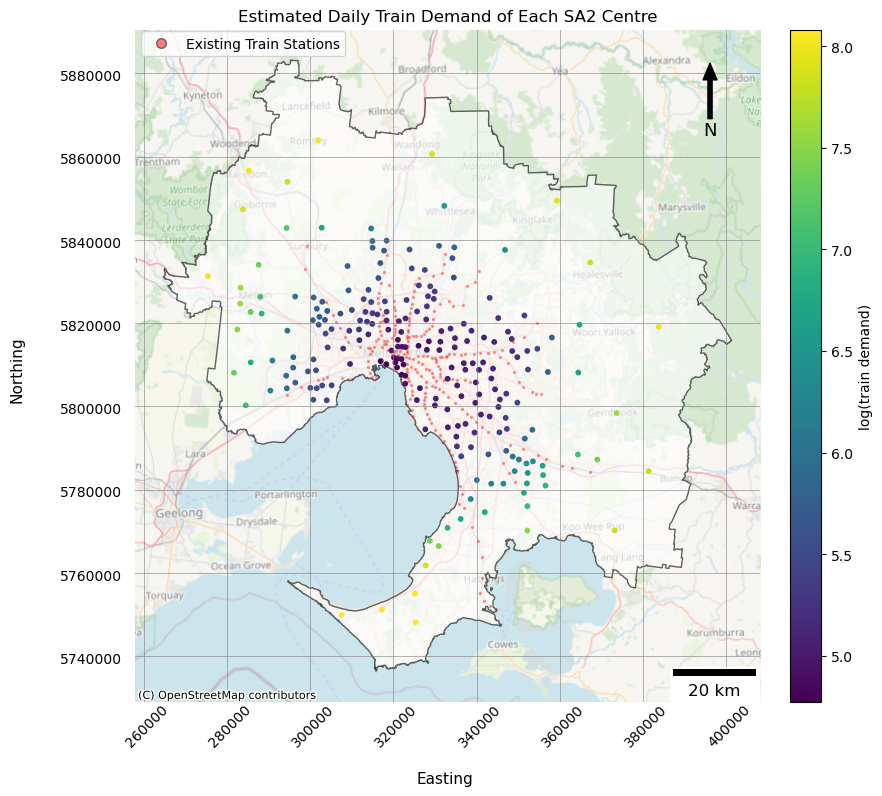

In [59]:
GNN_pred = pd.read_csv('output/agnn2_predictions_weekday_weekend_scaled.csv')

SA2 = gpd.read_file('data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
SA2 = SA2.to_crs("EPSG:7855")
SA2 = SA2[SA2['GCC_NAME21'] == "Greater Melbourne"]
SA2 = SA2[['SA2_NAME21', 'geometry']]

GNN_pred['Station Name'] = GNN_pred['Station Name'].apply(lambda x: x[5:])

# Get coordinates of SA2 centre
SA2_pred_demand_GNN = pd.merge(SA2, GNN_pred, left_on='SA2_NAME21', right_on='Station Name', how='inner')
centroid = SA2_pred_demand_GNN.centroid
SA2_pred_demand_GNN.drop(['SA2_NAME21', 'geometry'], axis=1, inplace=True)
SA2_pred_demand_GNN['geometry'] = centroid

SA2_pred_demand_GNN = gpd.GeoDataFrame(
    SA2_pred_demand_GNN, 
    geometry=gpd.points_from_xy(SA2_pred_demand_GNN.geometry.x, SA2_pred_demand_GNN.geometry.y)
)
SA2_pred_demand_GNN.crs = 'epsg:7855'
SA2_pred_demand_GNN['log_total'] = np.log(SA2_pred_demand_GNN['Predicted_Total_Demand'])

GCCSA = gpd.read_file('data/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp')
post_covid_stations = gpd.read_file('data/curated/stations/stations_postcovid.gpkg')
GCCSA = GCCSA.to_crs("EPSG:7855")
GreaterMelbourne = GCCSA[GCCSA['GCC_NAME21'] == 'Greater Melbourne']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.3)

GreaterMelbourne.plot(ax=ax, facecolor='White', linewidth=1, edgecolor='Black', alpha=0.6)

SA2_pred_demand_GNN.plot(column='log_total',
                ax=ax,
                cax=cax1,
                legend=True,
                legend_kwds={'label': "log(train demand)",'orientation': "vertical"},
                markersize=10)

post_covid_stations.plot(ax=ax,markersize=2, color='red', alpha=0.3)

legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Existing Train Stations')]  

ax.legend(handles=legend, loc=(0.01,0.96))

contextily.add_basemap(ax=ax, 
                       crs = SA2_pred_demand_GNN.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.6)
add_map_components(ax=ax, bound=GreaterMelbourne.total_bounds, interval=20000, arrow_pos='right')
ax.set_title('Estimated Daily Train Demand of Each SA2 Centre')
plt.tight_layout()
plt.show()

<div style="background-color:#E0EDFA;padding:1em;box-sizing: border-box;">

Although GNN appears to have very high performace from training, we observe this is not translated to inference on new points (i.e. not the stations which were in the training data) due to the design of the network. We found that as the SA2 is further away from existing train lines, GNN tends to produce very large estimates. This is due to GNN almost perfectly captures relationship between stations. Hence we only use GNN for feature impact analysis and use LGBM to make predictions for potential station locations (discussed later).

## 3. Results and Discussion
<a id="results"></a>

### 3.1 Result of ML models
Mean Squared Error (MSE) measures the difference between actual and predictive values, given the formula:

$$
    MSE = \frac{1}{n} \sum^{n}_{i=1}(y_i - \hat{y_i})^2
    $$

Since our response is normalised to range of [0, 1], the possible MSE also lies within this range

On the other hand, R-squared provides a direct interpretation about the proportion of variation in train demand that can be explained by our model, given by:
$$
    R^2 = 1 - \frac{\sum^{n}_{i=1}(y_i - \hat{y_i})^2}{\sum^{n}_{i=1}(y_i - \bar{y_i})^2} 
    $$




| Model | Training MSE | Validation MSE | Testing MSE | Out-of-Sample R-Squared |
| --- | --- | --- | --- | --- |
| Linear Regression | 0.2409 | 0.2634 | 0.5830 | 0.3495 |
| Support Vector Machine | 0.2793 | 0.3205 | 0.3856 | 0.5697 |
| Random Forest | 0.0266 | 0.1628 | 0.1882 | 0.7901 |
| XGB | 0.0840 | 0.1081 | 0.1519 | 0.8305 |
| LightGBM | 0.0515 | 0.0894 | 0.1233 | 0.8624 |
| GNN | 0.0140 | 0.0044 | 0.0043 | 0.9962 |

### 3.2 Error Analysis
From the previous section, we showed that our model can make overall reliable predictions. Now, by transform data back to original scale, and comparing the difference between demand in test data and our prediction, we can plot an error map to show the model's ability to make accurate prediction across the region.


In [60]:
test = pd.read_parquet('data/curated/ML_data/ML_test_data.parquet')
test_data = test.drop(['Station_Name', 'Business_Date', 'PublicHoliday', 'Date'], axis=1)
X_test = test_data.drop(['log_Total_Demand'], axis=1)

with open('output/lgbm_model.pkl', 'rb') as file:
    model = pickle.load(file)

y_pred_test = model.predict(X_test)

scaler = joblib.load('data/curated/ML_data/y_scaler.pickle')
test = test[['Station_Name', 'log_Total_Demand']]
y_test = test['log_Total_Demand']

test['log_pred'] = y_pred_test

# Fransform y and y_pred into original scale
test['Total Demand'] = scaler.inverse_transform(test[['log_Total_Demand']])
test['Total Demand'] = test['Total Demand'].apply(lambda x: np.exp(x))

test['Total Demand Pred'] = scaler.inverse_transform(test[['log_pred']])
test['Total Demand Pred'] = test['Total Demand Pred'].apply(lambda x: np.exp(x))

# Falculate absolute error
test['error'] = abs(test['Total Demand'] - test['Total Demand Pred'])
test = test[['Station_Name', 'error']]

# Find mean error for each station, according the number of business days
test_per_station = test.groupby('Station_Name').agg({'error': lambda x: np.sum(x)})
test_per_station['count'] = test.groupby('Station_Name').count()['error']
test_per_station.reset_index(inplace=True)
test_per_station['log(avg_error)'] = np.log(test_per_station['error'] / test_per_station['count'])


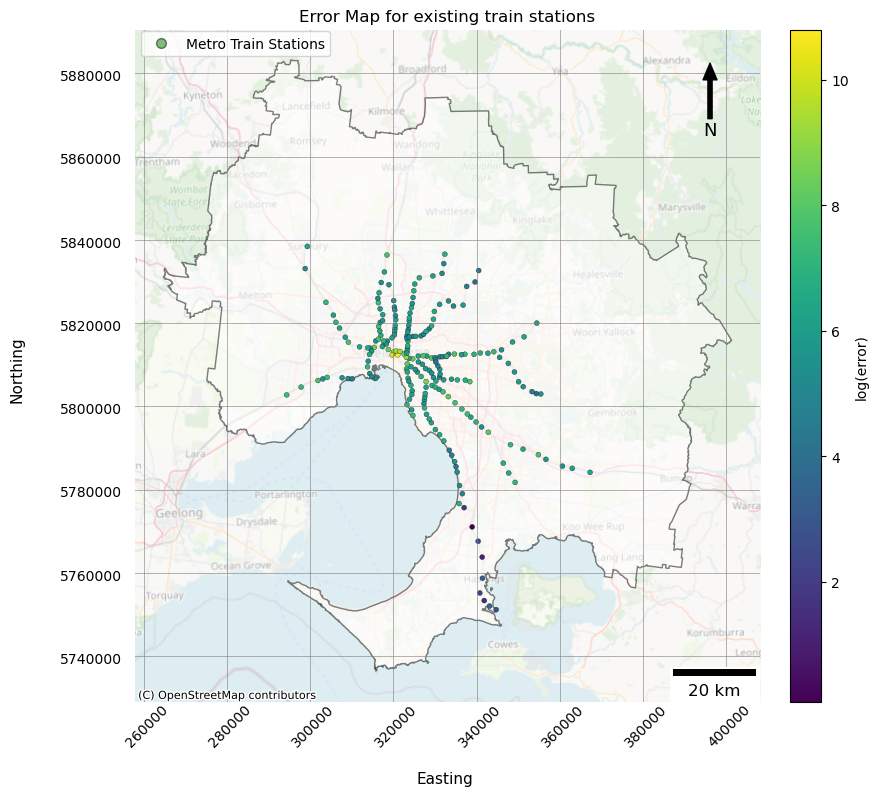

In [61]:
stations = gpd.read_file('data/curated/stations/stations_postcovid.gpkg')[['Station_Name', 'geometry']]
test_per_station = test_per_station.merge(stations, on='Station_Name')
test_per_station = gpd.GeoDataFrame(test_per_station)

GCCSA = gpd.read_file('data/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp')
GCCSA = GCCSA.to_crs("EPSG:7855")
GreaterMelbourne = GCCSA[GCCSA['GCC_NAME21'] == 'Greater Melbourne']
Greater_Melbourne = GCCSA.iloc[4]['geometry']

# Plot prediction error
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.3)

GreaterMelbourne.plot(ax=ax, facecolor='White', linewidth=1, edgecolor='Black', alpha=0.5)

test_per_station.plot(column='log(avg_error)',
                ax=ax,
                legend=True,
                cax = cax1,
                missing_kwds={'color': 'white',  # color for NaN values
                       'label': 'No Data'},
                legend_kwds={'label': "log(error)",'orientation': "vertical"},
                linewidth=0.2, edgecolor='Black',
                markersize=13)


contextily.add_basemap(ax=ax, 
                       crs = test_per_station.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.4)

legend = [Line2D([0], [0], marker='o', 
                        color='g',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Metro Train Stations')]  

ax.legend(handles=legend, loc=(0.01,0.96))

add_map_components(ax, bound=GreaterMelbourne.total_bounds, interval=20000, arrow_pos='right')
ax.set_title("Error Map for existing train stations")
plt.tight_layout()
plt.show()

<div style="background-color:#E0EDFA;padding:1em;box-sizing: border-box;">

We observed that in most stations, the difference between the actual demand and our predictions is under 1097 ($e^7$) people. However, there exist some special patterns, such as high error in stations near Melbourne CBD. 

Since we used Average Nearest Neighbour distance to calculate features, stations near Melbourne CBD may have very similar feature values. Therefore, our models may not be able to capture variations when stations are too close to each other. Although this suggests a possible limitation of our analysis, the prediction of other regions remain significant.

### 3.3 Train Demand Prediction
During inference to predict future demand, only 2 instances are created for each station/sa2: one for inferencing mean weekday demand and one for mean weekend demand. The log-mean demand of each station is used to replace the daily demands.

After predictions are made for each station, all predictions are reverse-Z-scored, exponentialised, and the

$$
\text{final\_demand} = \frac{5}{7} \cdot \hat{\text{weekday\_demand}} + \frac{2}{7} \cdot \hat{\text{weekend\_demand}}
$$

In [62]:
lgbm_model = joblib.load('output/lgbm_model.pkl')
data = pd.read_parquet('data/curated/ML_data/SA2_ML_data.parquet')

# Separate weekday and weekend demand
n = int(len(data) / 2)
pred = lgbm_model.predict(data.drop(['Station Name'], axis=1))
pred_weekday = pred[:n]
pred_weekend = pred[n:]

SA2 = list(data['Station Name'])[:n]
SA2_demand = pd.DataFrame([SA2, pred_weekday, pred_weekend], index=['SA2', 'log_demand_weekday', 'log_demand_weekend']).T

scaler = joblib.load('data/curated/ML_data/y_scaler.pickle')

SA2_demand['demand_weekday'] = scaler.inverse_transform(SA2_demand[['log_demand_weekday']])
SA2_demand['demand_weekday'] = SA2_demand['demand_weekday'].apply(lambda x: np.exp(x))

SA2_demand['demand_weekend'] = scaler.inverse_transform(SA2_demand[['log_demand_weekend']])
SA2_demand['demand_weekend'] = SA2_demand['demand_weekend'].apply(lambda x: np.exp(x))

# Combine them together
SA2_demand['total_demand'] = (SA2_demand['demand_weekday'] * 5 + SA2_demand['demand_weekend'] * 2) / 7
SA2_demand.to_csv('output/demand_predictions.csv', index=False)

In [63]:
pred_demand = pd.read_csv('output/demand_predictions.csv')

SA2 = gpd.read_file('data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
SA2 = SA2.to_crs("EPSG:7855")
SA2 = SA2[SA2['GCC_NAME21'] == "Greater Melbourne"]
SA2 = SA2[['SA2_NAME21', 'geometry']]

SA2_pred_demand = pd.merge(SA2, pred_demand, left_on='SA2_NAME21', right_on='SA2', how='inner')
centroid = SA2_pred_demand.centroid
SA2_pred_demand.drop(['SA2_NAME21', 'geometry'], axis=1, inplace=True)
SA2_pred_demand['geometry'] = centroid

SA2_pred_demand = gpd.GeoDataFrame(
    SA2_pred_demand, 
    geometry=gpd.points_from_xy(SA2_pred_demand.geometry.x, SA2_pred_demand.geometry.y)
)
SA2_pred_demand.crs = 'epsg:7855'
SA2_pred_demand['log_total'] = np.log(SA2_pred_demand['total_demand'])

In [64]:
SA2_pred_demand.sort_values('log_total', ascending=False).head()

SA2  log_demand_weekday  log_demand_weekend  \
22                  Balwyn North            1.194438            1.008944   
5                        Carlton            0.914382            0.741316   
20                       Fitzroy            0.931960            0.530993   
10  West Melbourne - Residential            0.809582            0.600761   
46               Heidelberg West            0.810143            0.505544   

    demand_weekday  demand_weekend  total_demand  \
22    10215.963015     7330.101385   9391.431121   
5      6188.918887     4540.507520   5717.944211   
20     6386.695638     3116.281262   5452.291531   
10     5130.525351     3530.709335   4673.435061   
46     5135.676306     2977.539420   4519.065767   

                          geometry  log_total  
22  POINT (331289.272 5815547.154)   9.147553  
5   POINT (321086.983 5814374.362)   8.651365  
20  POINT (322086.274 5814337.138)   8.603791  
10  POINT (319518.245 5813443.034)   8.449650  
46  POINT (327874.890 5820904.804)   8.416061

<div style="background-color:#E0EDFA;padding:1em;box-sizing: border-box;">

We used point data for fitting the model so we have point estimates directly from the output. From the result, Balwyn North is the region with the highest train demand, and furthermore, it does not contain any train stations yet.

These results match domain knowledge, with Balwyn known to be an area of high demand, while West Melbourne has a booming migrant population. Carlton's 2nd place ranking justifies the Parkville Station construction as part of the city tunnel, as it is inside Carlton.

This potentially answers our second research question, it is highly recommended to extend the metro train network near these regions.


In [65]:
SA2_pred_demand.sort_values('log_total').head()

SA2  log_demand_weekday  log_demand_weekend  \
192                  Werribee - East           -1.773142           -1.927697   
187                           Melton           -1.743989           -1.724961   
197  Tarneit (West) - Mount Cottrell           -1.600480           -1.685234   
200                  Tarneit - South           -1.529762           -1.679194   
176        Rockbank - Mount Cottrell           -1.557709           -1.549467   

     demand_weekday  demand_weekend  total_demand  \
192       50.444849       38.255488     46.962175   
187       53.146551       54.987573     53.672558   
197       68.708909       59.039214     65.946139   
200       77.978871       59.680897     72.750879   
176       74.174664       75.276864     74.489578   

                           geometry  log_total  
192  POINT (294392.186 5804349.204)   3.849342  
187  POINT (288004.872 5826331.782)   3.982902  
197  POINT (290910.602 5811030.458)   4.188838  
200  POINT (294228.541 5807388.302)   4.287041  
176  POINT (294510.416 5818208.061)   4.310659

### 3.4 Visualisation
Apart from listing the SA2 with most/least train demands, we are also interested in the spatial distribution of the demand

In [ ]:
GCCSA = gpd.read_file('data/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp')
post_covid_stations = gpd.read_file('data/curated/stations/stations_postcovid.gpkg')
GCCSA = GCCSA.to_crs("EPSG:7855")
GreaterMelbourne = GCCSA[GCCSA['GCC_NAME21'] == 'Greater Melbourne']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.3)

GreaterMelbourne.plot(ax=ax, facecolor='White', linewidth=1, edgecolor='Black', alpha=0.6)

SA2_pred_demand.plot(column='log_total',
                ax=ax,
                cax=cax1,
                legend=True,
                legend_kwds={'label': "log(train demand)",'orientation': "vertical"},
                markersize=10)

post_covid_stations.plot(ax=ax,markersize=2, color='red', alpha=0.3)

legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Existing Train Stations')]  

ax.legend(handles=legend, loc=(0.01,0.96))

contextily.add_basemap(ax=ax, 
                       crs = SA2_pred_demand.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.6)
add_map_components(ax=ax, bound=GreaterMelbourne.total_bounds, interval=20000, arrow_pos='right')
ax.set_title('Estimated Daily Train Demand of Each SA2 Centre')
plt.tight_layout()
plt.savefig('output/point_estimate.png', dpi=300)
plt.show()

<div style="background-color:#E0EDFA;padding:1em;box-sizing: border-box;">

The color map shows the estimated train demand in each SA2 of Greater Melbourne, and the small red dots indicate current Metro train network coverage. We found that most high-demand locations are clustered near middle east of this region, and the demand decreases as it becomes more distant.

On the other hand, it is observed the existing metro network covers most high demand regions. However, some SA2 have relative high demand estimation but is not close to any existing stations. For example, Balwyn North (331289.272 N, 5815547.154 E) has highest demand prediction from the model, but no train stations pass its surrounding area.


### 3.5 Kriging
From previous steps, we derived a point estimate for train demand of every SA2 that does not currently have train stations. We want to extend this estimation to rasters. Raster data can provide a continuous surface representation, making it easier to visualise spatial patterns and trends. Additionally, it can help in detecting and analysing spatial patterns and anomalies that might not be evident from point data alone.

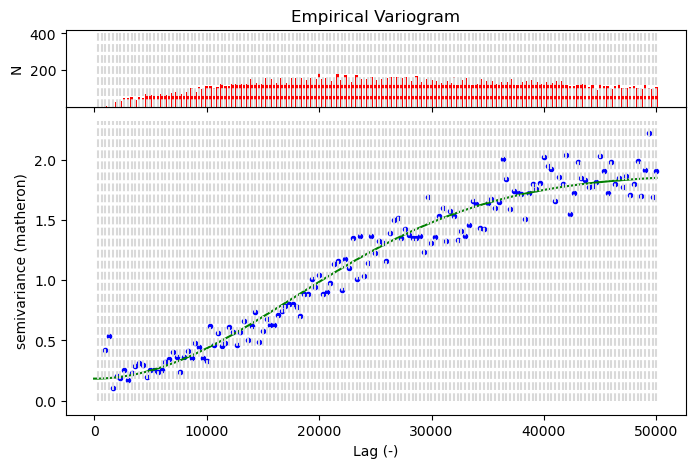

In [67]:
SA2_pred_demand['x'] = SA2_pred_demand.geometry.x.round(3)
SA2_pred_demand['y'] = SA2_pred_demand.geometry.y.round(3)
coords = SA2_pred_demand[['x', 'y']].values
demands = SA2_pred_demand['log_total'].values
V = skgstat.Variogram(coordinates = coords, values = demands, 
                      model = 'Gaussian', n_lags = 150,
                      maxlag = 50000,  use_nugget = True)

fig = V.plot(show = False)
plt.title('Empirical Variogram')
plt.show()

In [68]:
# Fit variogram model

ok = skgstat.OrdinaryKriging(V, min_points = 5, max_points = 20, mode='exact')
grid_size = 1000
vic_bounds = GreaterMelbourne.bounds
minX = vic_bounds.minx.values[0]
minY = vic_bounds.miny.values[0]
maxX = vic_bounds.maxx.values[0]
maxY = vic_bounds.maxy.values[0]
x_spacing = np.arange(minX, maxX, grid_size)
y_spacing = np.arange(minY, maxY, grid_size)
gridX, gridY = np.meshgrid(x_spacing, y_spacing)
interp_arr = ok.transform(gridX.flatten(), gridY.flatten()).reshape(gridX.shape)
# the Kriging error
interp_err_arr = ok.sigma.reshape(gridX.shape)
affine = from_origin(west = gridX[0][0], north = gridY[-1][0], xsize = grid_size, ysize = grid_size)

height = math.ceil((maxY - minY)/grid_size)
width = math.ceil((maxX - minX)/grid_size)
filename = 'output/kriging.tif'
with rasterio.open(filename,
                    'w', 
                    driver = 'GTiff', 
                    dtype = np.float32,
                    count = 1,
                    width=width,
                    height=height,
                    crs = 'EPSG:7855', 
                    transform = affine) as ds_out:

        ds_out.write(np.flip(interp_arr, axis = 0), 1)


In [69]:
def add_map_components_kriging(ax, bound, interval, arrow_pos=None):

    '''
        This function adds cartographic components on the map,
        including: Grid, Axes, Axes Label, North Arrow, Legends, Scale Bar
        It will be applied to every map later in the project
    '''
    # Add orientation arrow
    if arrow_pos == 'left':
        x, y, arrow_length = 0.08, 0.95, 0.1
    if arrow_pos == 'right':
        x, y, arrow_length = 0.92, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=3, headwidth=10),
                ha='center', va='center', fontsize=13, xycoords=ax.transAxes)
    
    # Add axis label
    ax.annotate('Northing', xy=(-0.2,0.45),
                fontsize=11, xycoords=ax.transAxes, rotation=90)
    ax.annotate('Easting', xy=(0.45,-0.12),
                fontsize=11, xycoords=ax.transAxes)
    
    # Remove unnecessary axis
    ax.set_axis_off()

    # Make some offest to avoid map touching boundary
    # Round to create whole number axis
    xmin, ymin, xmax, ymax = bound
    xmin = np.floor(xmin / interval - 0.2) * interval
    ymin = np.floor(ymin / interval - 0.2) * interval
    xmax = np.ceil(xmax / interval + 0.2) * interval
    ymax = np.ceil(ymax / interval + 0.2) * interval
    # Generate lines for graticule
    horizontal = np.arange(np.floor(ymin), np.ceil(ymax), interval)
    vertical = np.arange(np.floor(xmin), np.ceil(xmax), interval)

    # Plot horizontal lines
    for each in horizontal:
        line = LineString([(xmin, each), (xmax, each)])
        ax.annotate(f'{int(each)}', xy=(xmin+8000, each), xytext=(-60, -5),
                    textcoords="offset points")
        ax.plot(*line.xy, color='grey', linewidth=0.6, alpha=0.7)
    
    # Plot vertical lines
    for each in vertical:
        line = LineString([(each, ymin), (each, ymax)])
        ax.annotate(f'{int(each)}', xy=(each, ymin+17000), xytext=(-15, -35),
                    textcoords="offset points", rotation=45)
        ax.plot(*line.xy, color='grey', linewidth=0.6, alpha=0.7)

    # Add Scale Bar
    scalebar = ScaleBar(100, 'cm', 
                        length_fraction=0.15, 
                        location='lower right', 
                        frameon=True, 
                        color='black', 
                        scale_loc='bottom', label_loc='bottom', 
                        font_properties={'size': 12})
    
    ax.add_artist(scalebar)

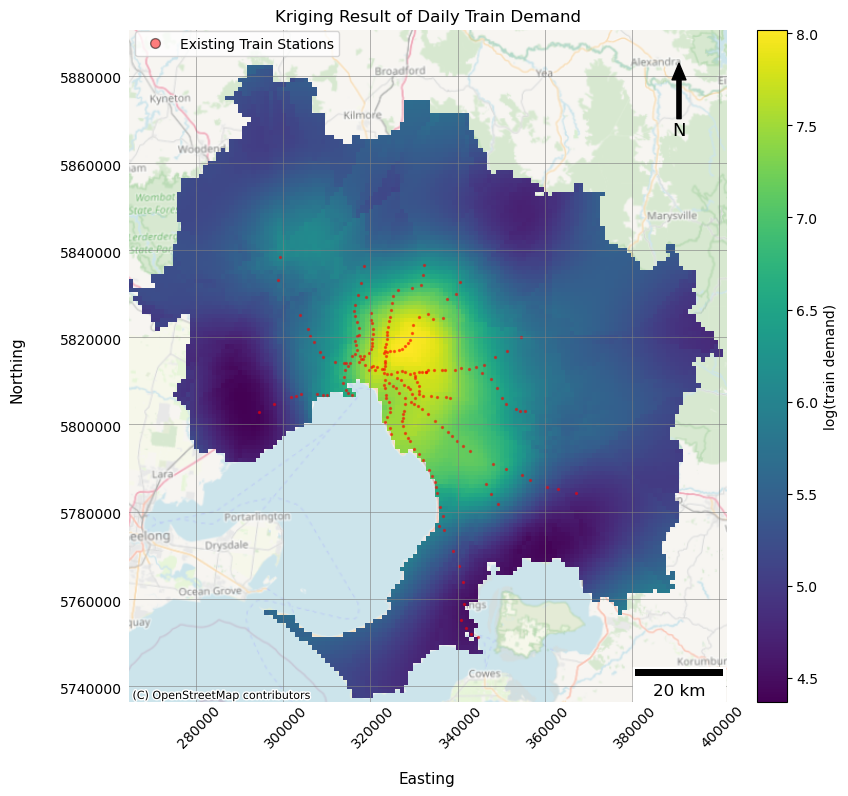

In [70]:
with rasterio.open('output/kriging.tif', 'r') as ras:
    profile = ras.profile
    masked_ras, masked_ras_transform = rasterio.mask.mask(dataset = ras, 
                                                          shapes = GreaterMelbourne.geometry, 
                                                          nodata = np.NaN, 
                                                          crop = True)
masked_ras_profile = profile.copy()
masked_ras_profile['height'] = masked_ras.shape[1]
masked_ras_profile['width'] = masked_ras.shape[2]
masked_ras_profile['transform'] = masked_ras_transform

temp_raster_file = 'output/kriging_masked.tif'

with rasterio.open(temp_raster_file, 'w', **masked_ras_profile) as ds_out:
    ds_out.write(masked_ras)

with rasterio.open(temp_raster_file, 'r') as ds:
    img_arr = ds.read(1)

# assigning nodata value as NaN
img_arr[img_arr == ds.nodata] = np.NaN

fig, ax = plt.subplots(figsize = (10, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.3)



GreaterMelbourne.plot(ax=ax, facecolor='None', linewidth=0)



im = rasterio.plot.show(img_arr, ax = ax, transform = ds.transform) # cmap = 'viridis'
im = im.get_images()[0]
fig.colorbar(im, cax=cax, orientation='vertical', label='log(train demand)')

post_covid_stations.plot(ax=ax, color='red', alpha=0.5, markersize=2)

legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Existing Train Stations')]  

ax.legend(handles=legend, loc=(0.01,0.96))

contextily.add_basemap(ax=ax, 
                       crs = GreaterMelbourne.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.6)

im = rasterio.plot.show(img_arr, ax = ax, transform = ds.transform) # cmap = 'viridis'
im = im.get_images()[0]

fig.colorbar(im, cax=cax, orientation='vertical', label='log(train demand)')
add_map_components_kriging(ax=ax, bound=ds.bounds, interval=20000, arrow_pos='right')

ax.set_title('Kriging Result of Daily Train Demand')
plt.tight_layout()
plt.savefig('output/kriging_estimate.png', dpi=300)
plt.show()


<div style="background-color:#E0EDFA;padding:1em;box-sizing: border-box;">

From the kriging interpolation, we found that except for some areas in the north and northwest are distorted because there are very few points available, most regions present a smooth pattern of the demand. This definitely provides us with additional insights about train station recommendations. For example, there is the highest demand in the east of Melbourne City, but there are no train lines going through that.

On the other hand, we can see some lines terminate when there are still demands beyond that (Lilydale, Belgrave, Glen Waverley), suggesting they may need to extend further.


## 4 Discussion
<a id="discussion"></a>

### 4.1 Models

From the model performance table, we can see that Graph Neural Network performs the best with 0.9962 $R^2$ out of sample. Light Gradient Boost regressor is the second best performing while Random Forest (which has weaker inductive bias than boosters) is ranked third.

This is likely due to the inherent autocorrelation in geographic data. Although we applied geographically weighted features to all regression models, GNN can encode additional non-linear dependencies through graph representation, further justifying the significance of the spatial property in this task.

### 4.2 Quantitative Feature Analysis


Ordinary Least Squares (Linear Regression) has the ability to provide quantitative explanations of the impact on the dependent variable that changing the independent variables have, through the value of the weight coefficents. It is also able to determine whether each independent variable has statistically significant effects on the dependent variable using t-tests. We approximate this behaviour on the Graph Neural Network by putting a linear layer (linear regression) on top of the Graph Neural Network so the GNN can both capture the non-linear spatial relationships while also producing linear quantitative effects. Below is a table of the coefficients

| Model | Linear Layer Coefficient | GNN Linear Layer Coefficients |  
| --- | --- | --- | 
| Weighted sum of demand of other stations | N/A | 0.3000 |  
| Weekday | -0.039 | 0.0085 |  
| School | 0.700 | 0.0003 |  
| Hospital | 0.410 | 0.0025 |  
| Sport facilities | -0.060 | 0.0020 |  
| Shopping Centres | 0.490 | 0.0121 |  
| Mean Rainfall | -0.570 | -0.0023 |  
| Total Population | 0.486 | 0.0218 |  
| Median weekly rent | -0.410 | -0.0027 |  
| Median weekly mortgage | 0.410 | -0.0074 |  
| Median weekly income |  0.570| -0.0047 |  
| Median weekly household income | -0.770 | 0.0109 |  

Since the target here is log(demand), each 1 unit increase in each variable (standard deviation for continuous variables, or going from no building/not weekend to have building/weekend) will impact demand by increasing $100 \cdot \beta$%. For weighted other stations demand, because the feature itself is also logged, 1 sd movement in weighted other stations demand will cause $\beta$% change in demand for this station.

Through this observation, it is clear that Linear Regression's interpretation is corrupted, as the signs are often in inverse direction compared to our hypothesis, and the magnitude of coefficients are really large (i.e. one wouldn't expect 1 sd increase in average rainfall in melbourne to cause 57% decrease in demand, which is what the Mean Rainfall coefficient of -0.57 is suggesting). While all the linear regression coefficients are still highly statistically significant, it is likely that when applying linear regression to features that have spatial correlation (i.e. stations) it has violated i.i.d. assumptions of the model, which has caused t-stats to be more significant than they should be, while corrupting interpretations. This suggests that while our weighting method for demand can allow Machine Learning models to produce good predictions, it is not useful for interpretation.

On the contray, the 2 layer GNN was able to match our hypothesis. Its analysis of the quantitative impacts of the features are as follows:

- 1% increase in weighted sum of nearby stations has **0.3% increase** in demand for this station
- Weekday has **0.85% more demand** compared to weekend
- Stations with schools nearby has **0.03% demand increase**
- Stations with hospitals nearby has **0.25% demand increase**
- Stations with sports facilities nearby has **0.2% demand increase**
- Stations with shopping centres nearby has **1.21% demand increase**
- 1sd increase in mean rainfall has **0.23% demand decrease**
- 1sd increase in total population has **0.27% demand decrease**
- 1sd increase of meadian nearby weekly mortgage has **0.74% demand decrease**
- 1sd increase of median nearby weekly income has **0.47% demand decrease**
- 1sd increase of median nearby weekly household income has **1.09% demand increase**

*All standard deviation are based on the sample of Greater Melbourne.*

A useful effect of having 2 layer GNN is that secondary effects of circular impacts (i.e. station of interests' demand impacts other stations' demand, which also impacts the station of interests' demand) can be captured, and this is something that the Linear Regression cannot do. This is similar to simultaneous causality models in econometrics.

### 4.3 Sustainability and Resiliance

Understanding the demand for trains based on residential and non-residential factors helps in optimising the allocation of resources. Train services can be adjusted to match the demand, reducing energy consumption and emissions associated with underutilised services. Integrating train demand data with urban planning can ensure that new residential and commercial developments are well-connected to public transport networks. This promotes sustainable urban growth by reducing the need for car travel and encouraging the use of public transportation.

On the other hand, The findings can be used to identify vulnerabilities in the transport network and prioritise investments in infrastructure resilience. This includes reinforcing tracks and ensuring that stations are equipped to handle increased demand during different events.


### 4.4 Limitations and Future Work

While the models that produced the predictions are accurate and confidently matches domain knowledge, several limitations persists:

1. Stations can not be considered for construction independently, rather as part of a train line. Hence, multiple suburbs forming a potential train line should be evaluated together for more rounded analysis. This is something that our model fails to do and a more formal analysis should be conducted in this way using our model and more domain knowledge.

2. Empirical factors sometimes are vital when deciding the location of traffic infrastructures. For example, the elevation of land in potential rail lines should be heavily considered, as it may physically impede the ability to construct rail lines. On the other hand, hydrology and other land uses may also impact empirical design (Song et al., 2021). 

Future works:

1. Incorporate more up to date data and more features into the model for analysis and potentially better predictability. Our current analysis uses census data from 2021 which is serviceable but not precise.

2. Work on GNN's model architecture design to allow its excellent analysis abilities to be transferred to inference.

3. Spatial Temporal forecasting of daily train demand.

## 5. Conclusion
<a id="conclusion"></a>

We investigated the quantitative impact that weather, non-residential building and population features had on train station demand, and used predicted demand at each SA2 centre to predict which area should be prioritised for their first station. Quantitative analysis using Graph Neural Network indicated the existance of buildings and greater population to have positive impact on demand, while higher average rainfall and greater median wealth to have negative impacts on train demand. Using Light Gradient Boost Regressor, we forecast Balwyn North, Carlton, Fitzroy, West Melbourne and Hidelberg West to be the top 5 SA2s that should be prioritised for new stations, and this matches domain knowledge (i.e. West Melbourne's booming migrant population, Parkville station being built in Carlton etc). The results of this research can contribute towards more efficient public transport in Greater Melbourne, promoting the cause of sustainability and better liveability.

## References
[1] Alamri, S., Adhinugraha, K., Allheeib, N., & Taniar, D. (2023). Gis analysis of adequate accessibility to public
transportation in metropolitan areas. *ISPRS International Journal of Geo-Information, 12*(5).

[2] Department of Transport and Planning. (2023). *Department of transport and planning annual report 2022-23.*

[3] Fotheringham, A. S., Oshan, T. M., & Li, Z. (2023). *Multiscale geographically weighted regression: Theory and
practice* (1st ed.). CRC Press.

[4] Polat, C., et al. (2016). The demand determinants for urban public transport services: a review of the literature.

[5] Saghapour, T., Moridpour, S., & Thompson, R. G. (2016). Public transport accessibility in metropolitan areas:
A new approach incorporating population density. *Journal of Transport Geography, 54,* 273-285.

[6] Selby, B., & Kockelman, K. M. (2013). Spatial prediction of traffic levels in unmeasured locations: applications
of universal kriging and geographically weighted regression. *Journal of Transport Geography*, 29, 24–32.

[7] Song, T., Pu, H., Schonfeld, P., Zhang, H., Li, W., Peng, X., . . . Liu, W. (2021). Gis-based multi-criteria railway
design with spatial environmental considerations. *Applied Geography*, 131, 102449.
